Jafari Tadi M, Koivisto T, Pänkäälä M, Paasio A. Accelerometer-Based Method for Extracting Respiratory and Cardiac Gating Information for Dual Gating during Nuclear Medicine Imaging. Int J Biomed Imaging. 2014;2014:690124. doi: 10.1155/2014/690124. Epub 2014 Jul 10. PMID: 25120563; PMCID: PMC4120481.

# IMPORTING LIBRARIES

In [1]:
import os
from kinopy.io import read_record
from scipy.signal import detrend, find_peaks, medfilt
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
import neurokit2 as nk
from psd2 import psd2
from kinopy.commons.types import Number
from typing import Sequence, Optional, Literal, Tuple
import scipy.stats as st

# DATA LOADING

In [2]:
main_path = "/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/"
path_all = []
for i in sorted(os.listdir(main_path)):
    sub_path = os.path.join(main_path, i)
    sub = sorted(os.listdir(sub_path))
    for k in sub:
        subsub_path = os.path.join(sub_path, k)
        subsub = sorted(os.listdir(subsub_path))
        if len(subsub) == 2:
            path_all.append((os.path.join(subsub_path, str(subsub[0]))))
            path_all.append((os.path.join(subsub_path, str(subsub[1]))))
        else:
            path_all.append((os.path.join(subsub_path, str(subsub[0]))))
            
path_all

['/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/BDC10/K-ICB_A_BDC10_20190330-101553_gwoB4aykkTA8fy',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/BDC9/K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/BDC9/K-ICB_A_BDC9_20190331-112912_BKe5wrlWOhVETk',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/FAM/K-ICB_A_FAM_20190330-100233_vk0azV9DkUKXi4',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/HDT21/K-ICB_A_HDT21_20190429-110822_gwoxGB2nzSA8fy',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/HDT5/K-ICB_A_HDT5_20190413-090257_BKe0M07rPhVETk',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/HDT56/K-ICB_A_HDT56_20190603-110736_gwokQXN5vFA8fy',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/R1/K-ICB_A_R1_20190609-131324_bB5V5zalQtYqid',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/R1/K-ICB_A_R1_20190609-132625_bB5V5pwQQSYqid',
 '/home/giuseppeditursi

In [3]:
measurement = path_all[1]
record = read_record(measurement)
record

<Record 'K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk' (signals: 3, segmentations: 0, metrics: 0)>
Meta Data:
    id                      K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk
    code                    BDC9
    date                    2019-03-31T11:15:11+00:00
    subject                 A | Male | 1.8m | 72.8kg
    phone                   iPhone | iOS N/A | sw:2018.0.3.2
    device                  1.06 | hw:2017.0 | fw:2018.0.4.0
Signals:
    'ecg'                   electric/ecg        (451.06s, 200Hz)
    'scg'                   mechanical/scg      (451.06s, 200Hz)
    'bcg'                   mechanical/bcg      (451.06s, 200Hz)

In [4]:
fs = 200

In [5]:
scg = record.signals["scg"]
scg

<Biosignal 'scg' mechanical/scg (451.06s, 200Hz)>
Subsignals:  dis, vel, acc
Dimensions:  (motion: 2, time: 90212, axis: 3)

In [6]:
x = 0
y = 1
z = 2

# Lin
typ = 0
s1 = detrend(scg.vel[typ][:,x])      
s2 = detrend(scg.vel[typ][:,y])      
s3 = detrend(scg.vel[typ][:,z])      

# Rot
typ = 1
s4 = detrend(scg.vel[typ][:,x])       
s5 = detrend(scg.vel[typ][:,y])        
s6 = detrend(scg.vel[typ][:,z])  

# DATA PROCESSING

## RESPIRATION EXTRACTION

In [7]:
time_frame = [10.806, 50.806]

### Moving Average

In [8]:
def moving_average_simple(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def moving_average_cum(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

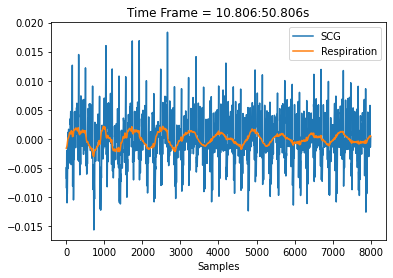

In [9]:
order = 200
resp = moving_average_simple(s6, order)
s6_cut = s6[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(s6_cut)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')
plt.legend(['SCG', 'Respiration'])

### Median Filter

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

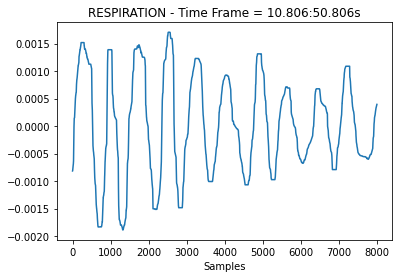

In [10]:
kernel_t = 1    # kernel duration (s)
kernel_smp = kernel_t*fs  
resp = medfilt(resp, int(kernel_smp)+1)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

The number of points (order) for 1D median and moving-average filters was defined based on the nature of the outcome signal from the filter.

### Cleaning

Khodadad et al. (2018) <https://iopscience.iop.org/article/10.1088/1361-6579/aad7e6/meta>

BioSPPy <https://github.com/PIA-Group/BioSPPy/blob/master/biosppy/signals/resp.py>

Clean a respiration signal using different sets of parameters, such as 'khodadad2018' (linear detrending followed by a fifth order 2Hz low-pass IIR Butterworth filter) or 'BioSPPy' (second order 0.1 - 0.35 Hz bandpass Butterworth filter followed by a constant detrending).

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

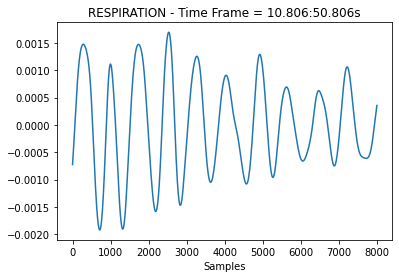

In [11]:
resp = nk.rsp.rsp_clean(resp)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

### Detrending

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

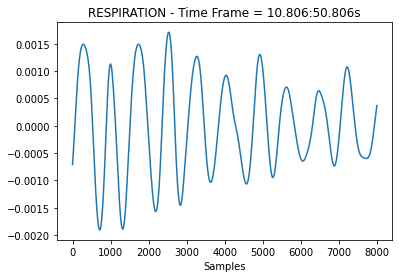

In [12]:
resp = detrend(resp)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

### Normalization

In [13]:
def scale_normalization(
    arr: np.ndarray,
    mode: Literal["range", "sum", "rss", "rms"] = "range",
    rg: Optional[Tuple[float, float]] = None,
) -> np.ndarray:
    """
    1D array
    """
    mx = np.max(arr)
    mn = np.min(arr)
    d = mx - mn
    if d == 0:
        return np.zeros_like(arr)
    s = arr - mn
    if mode == "range":
        if rg is None:
            rg = 0.0, 1.0
        ba = rg[1] - rg[0]
        a = rg[0]
        return (s * ba / d) + a
    elif mode == "sum":
        return s / np.sum(s)
    elif mode == "rss":
        return s / np.sqrt(np.sum(np.square(s)))
    elif mode == "rms":
        return s / np.sqrt(np.sum(np.square(s)) / len(s))

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

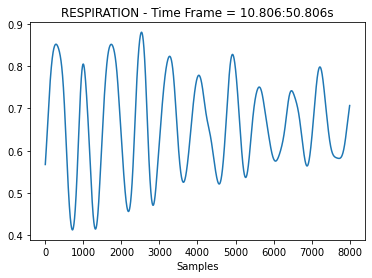

In [14]:
resp = scale_normalization(resp, rg=(-1, 1))
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

### Standardization

In [15]:
def interquartile_range(
    arr: np.ndarray, q: Optional[Sequence[Number]] = None, axis: int = 0
) -> float:
    """
    1D array
    """
    if q is None:
        q = [25, 75]
    return st.iqr(arr, axis=axis, rng=q, nan_policy="omit")

def scale_standardization_robust(
    arr: np.ndarray, q: Optional[Sequence[Number]] = None, axis: int = 0
) -> np.ndarray:
    return (arr - np.median(arr, axis=axis)) / interquartile_range(arr, q, axis=axis)

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

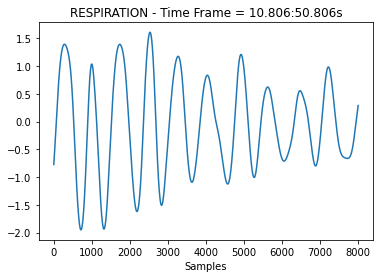

In [16]:
resp = scale_standardization_robust(resp)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

### Correction Respiration Sign

In [17]:
def _correct_rsp_sign(
    rsp: np.ndarray, fs: int, distance_ms: int, prominence: float
) -> np.ndarray:
    distance = int(distance_ms * fs / 1000)
    rsp_max_idx, _ = find_peaks(rsp, distance=distance, prominence=prominence)
    rsp_min_idx, _ = find_peaks(-rsp, distance=distance, prominence=prominence)

    i = 0
    j = 0
    lengths_min_max = []
    lengths_max_min = []

    prev_min_max = False
    prev_max_min = False

    while i < len(rsp_min_idx) and j < len(rsp_max_idx):
        min_i = rsp_min_idx[i]
        max_j = rsp_max_idx[j]

        if min_i < max_j:
            length = max_j - min_i
            if not prev_min_max:
                lengths_min_max.append(length)
            prev_min_max = True
            prev_max_min = False
            i += 1
        else:
            length = min_i - max_j
            if not prev_max_min:
                lengths_max_min.append(length)
            prev_min_max = False
            prev_max_min = True
            j += 1

    length_med_min_max = np.median(lengths_min_max)
    length_med_max_min = np.median(lengths_max_min)

    if length_med_min_max > length_med_max_min:
        rsp_corr = -rsp
    else:
        rsp_corr = rsp

    return rsp_corr

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

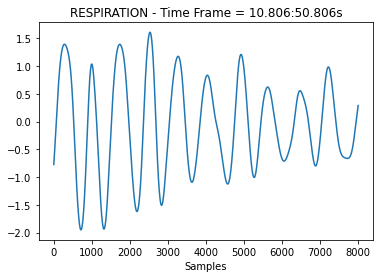

In [18]:
distance_ms = 1000
prominence = 0.25
resp = _correct_rsp_sign(resp, fs, distance_ms=distance_ms, prominence=prominence)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

## RESPIRATION PERIOD COMPUTATION

In [19]:
time_points = [10.806, 50.806, 110.806, 190.806, 290.806]
time_frames = [[time_points[i], time_points[i + 1]]
        for i in range(len(time_points) - 1)]

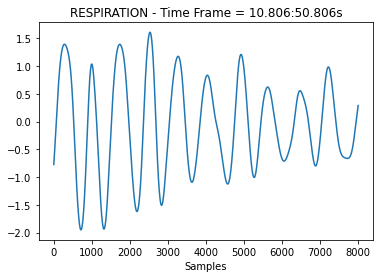

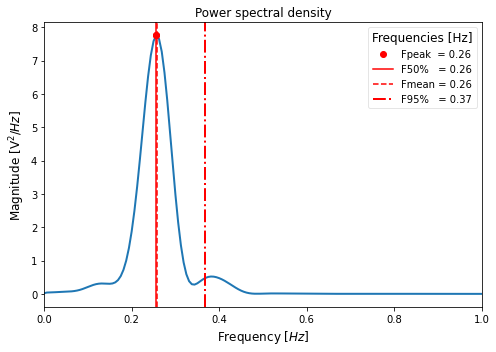

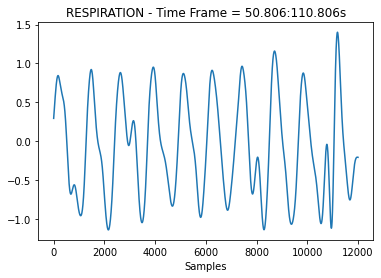

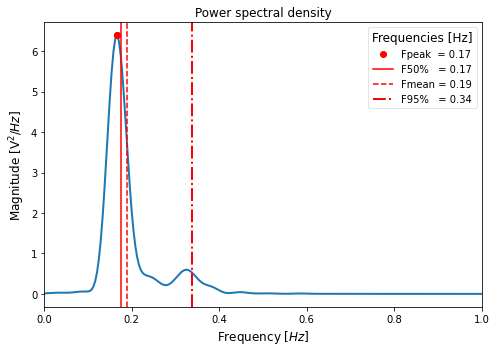

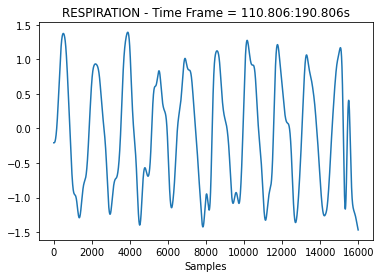

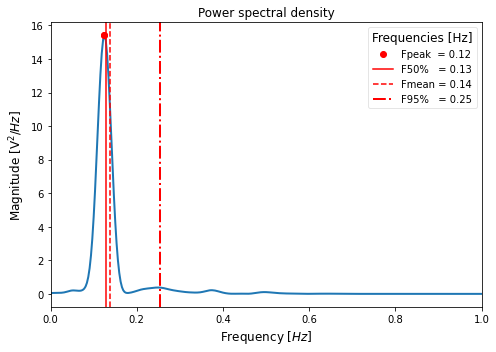

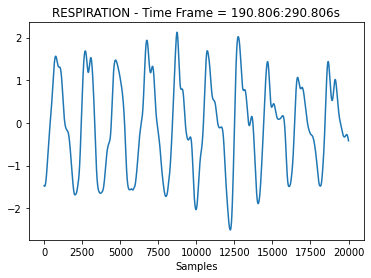

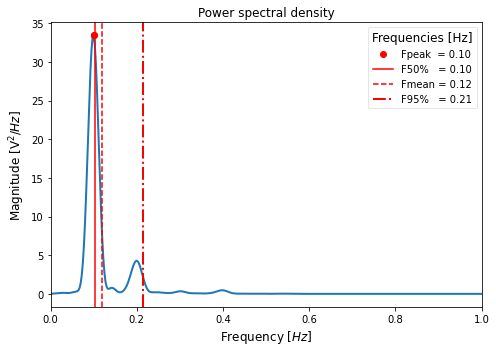

In [20]:
resp_period_all_comp = []

for k in time_frames:
    resp_cut = resp[int(k[0]*fs):int(k[1]*fs)]
    plt.figure()
    plt.plot(resp_cut)
    plt.xlabel('Samples')
    plt.title('RESPIRATION - Time Frame = ' +str(k[0])+ ':' +str(k[1])+ 's')
    fpcntile, mpf, fmax, Ptotal, f, P = psd2(resp_cut-np.mean(resp_cut), fs=fs, nfft=8*np.ceil(len(resp_cut)/2), show=True, xlim=(0, 1))
    resp_period = 1/fmax
    resp_period_all_comp.append(resp_period)

Text(0.5, 1.0, 'Sub-A/BDC9/K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk\nMAE: 0.02s')

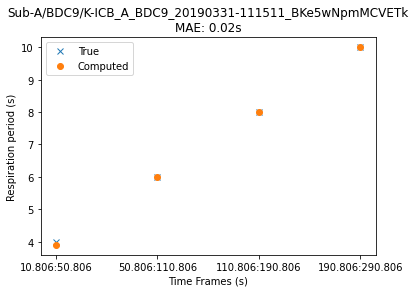

In [21]:
main_path = os.path.normpath(measurement)
sec_path = main_path.split(os.sep)
sec_path = sec_path[7]+'/'+sec_path[8]+'/'+sec_path[9]

resp_period_all_true = [4, 6, 8, 10]
err = mean_absolute_error(resp_period_all_true, resp_period_all_comp)
plt.figure()
x = np.array([0,1,2,3])
my_xticks = ['10.806:50.806','50.806:110.806','110.806:190.806','190.806:290.806']
plt.xticks(x, my_xticks)
plt.plot(my_xticks, resp_period_all_true, 'x')
plt.plot(my_xticks, resp_period_all_comp, 'o')
plt.xlabel('Time Frames (s)')
plt.ylabel("Respiration period (s)")
plt.legend(['True', 'Computed'])
plt.title(sec_path+ '\nMAE: ' +str(format(err, ".2f"))+ 's')

For all measurements.

In [22]:
del path_all[96]
del path_all[227]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/tmp/ipykernel_41926/882911179.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


/home/giuseppeditursi/.cache/pypoetry/virtualenvs/kino-core-7fM3i_G6-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/giuseppeditursi/.cache/pypoetry/virtualenvs/kino-core-7fM3i_G6-py3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


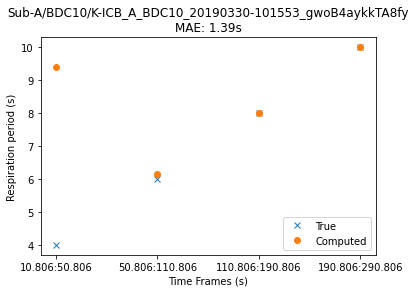

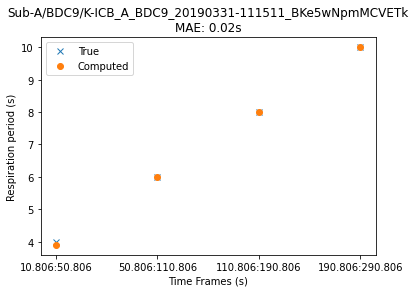

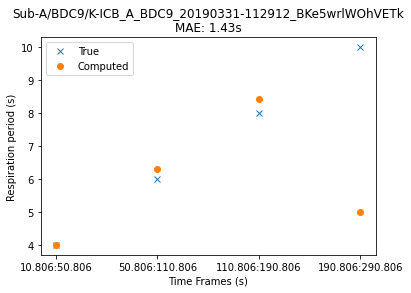

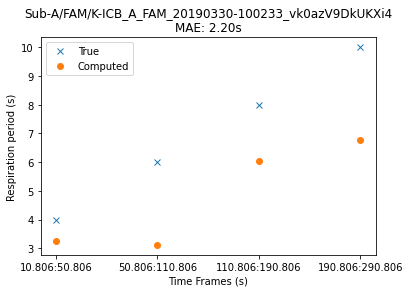

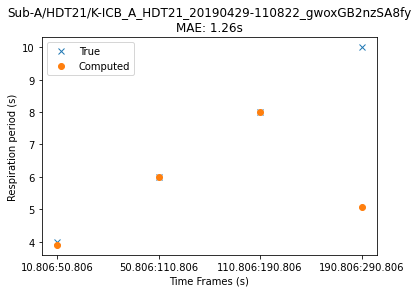

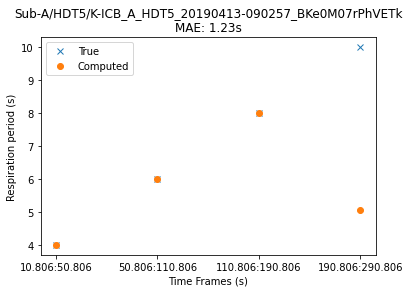

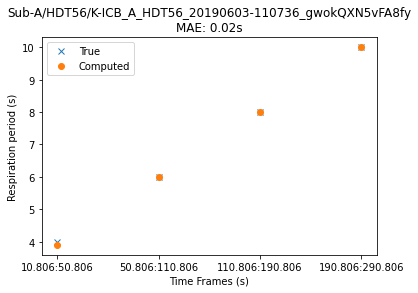

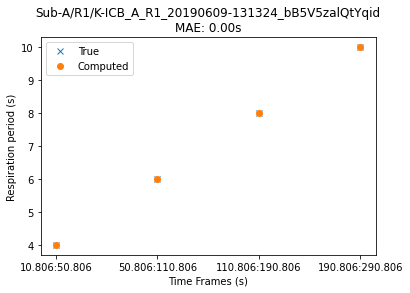

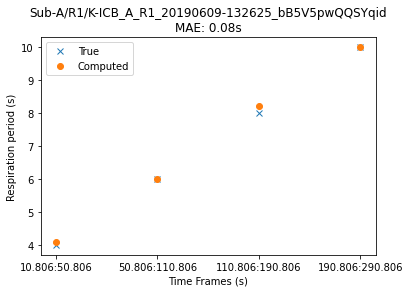

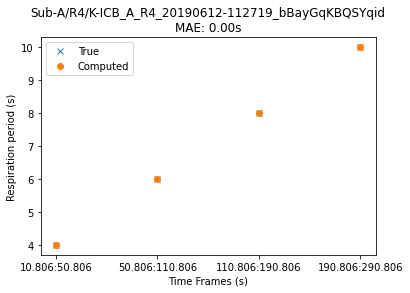

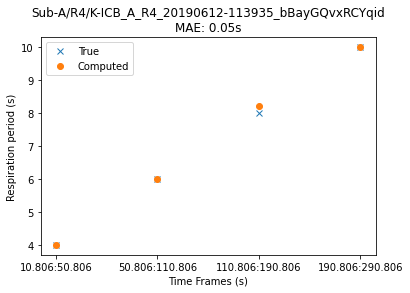

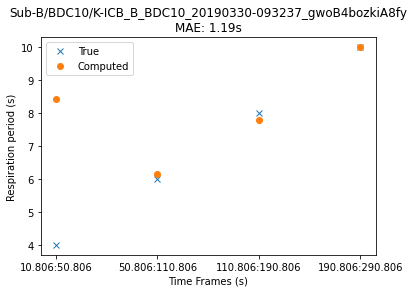

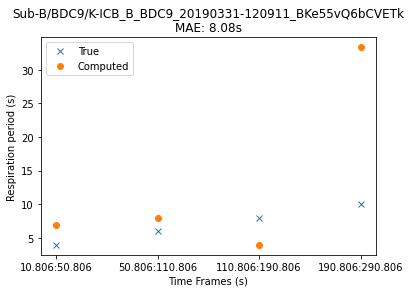

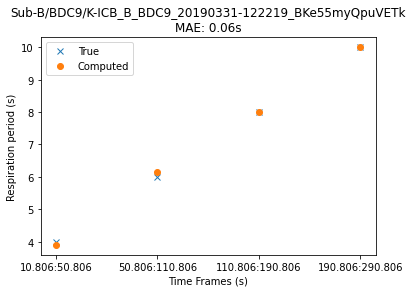

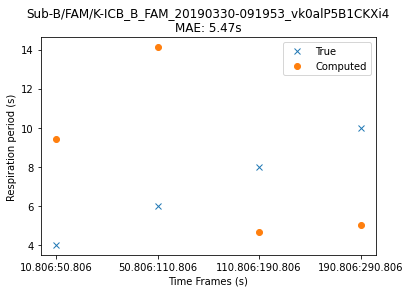

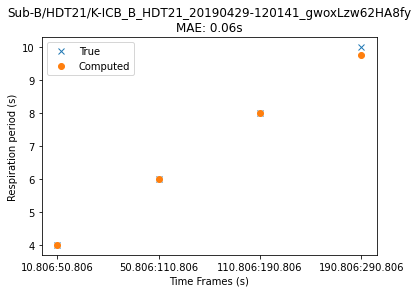

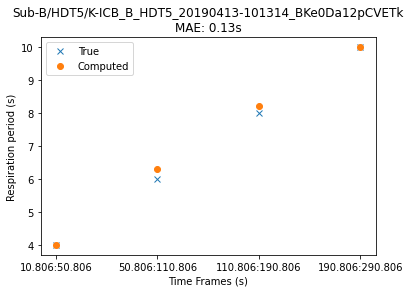

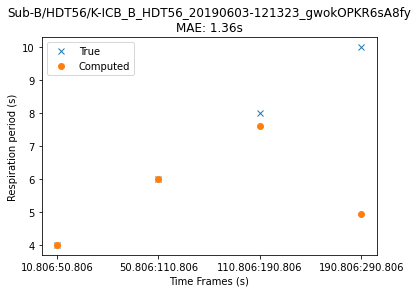

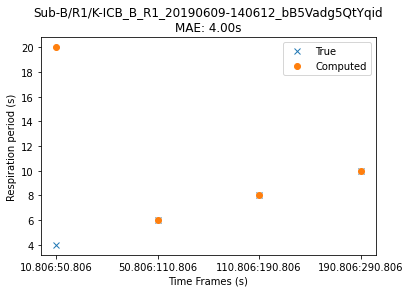

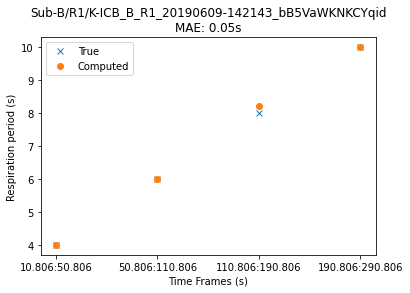

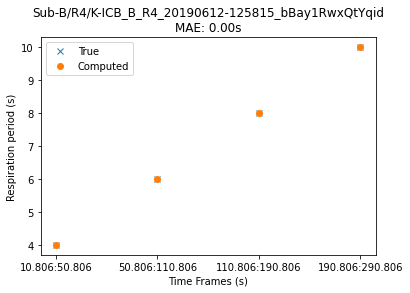

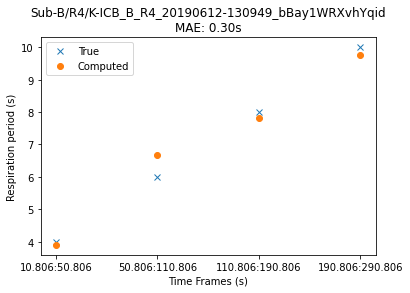

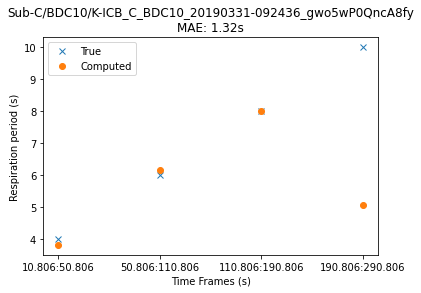

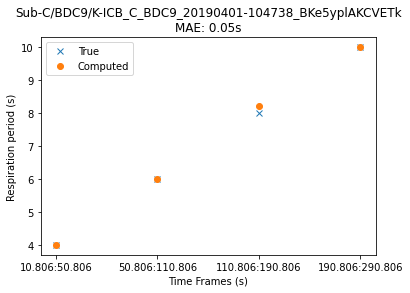

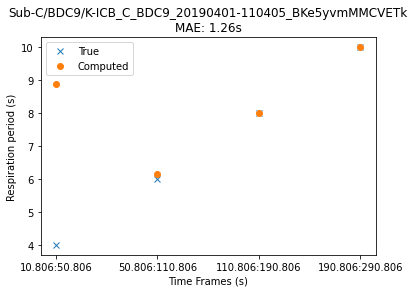

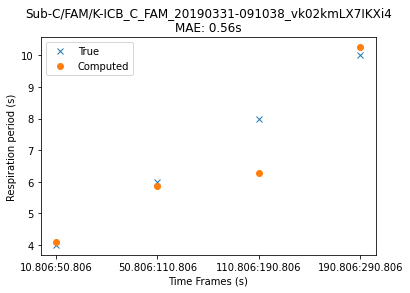

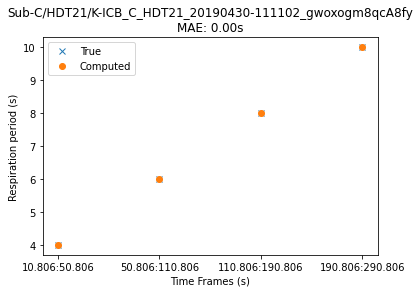

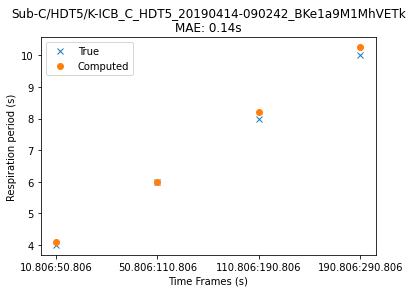

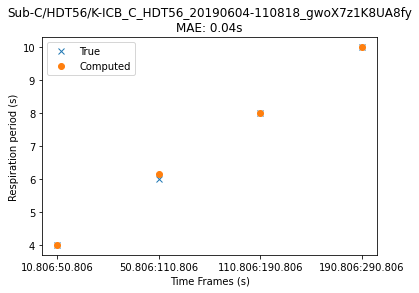

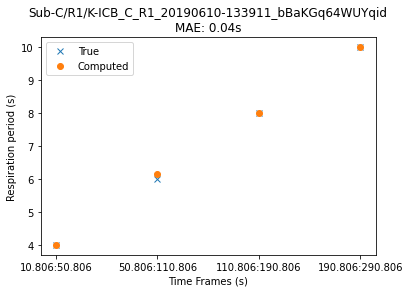

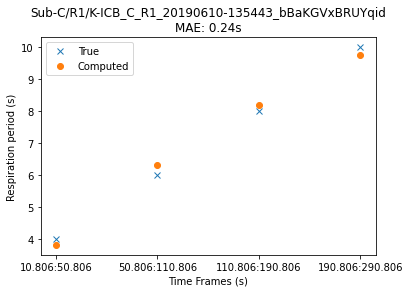

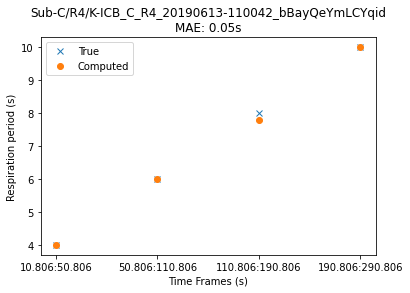

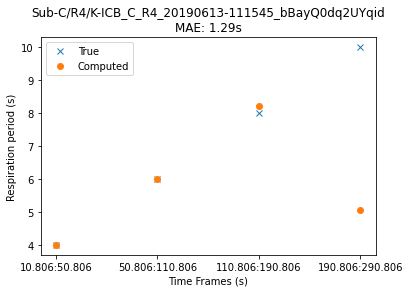

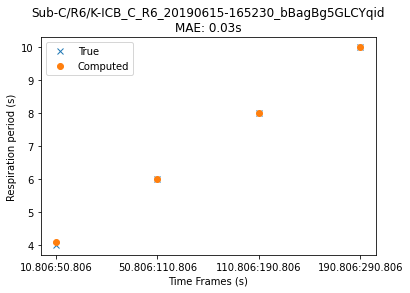

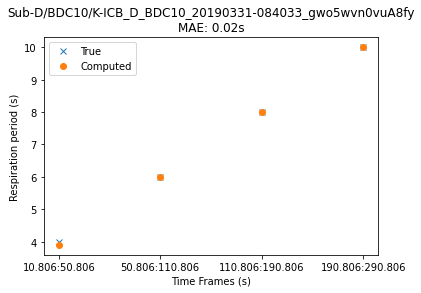

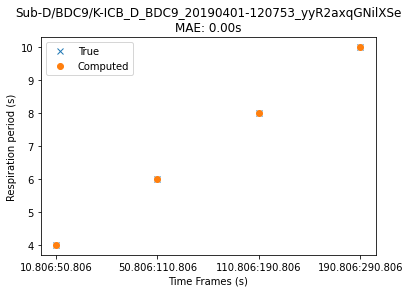

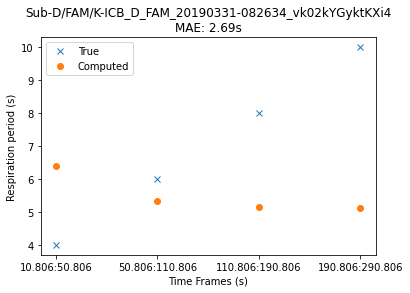

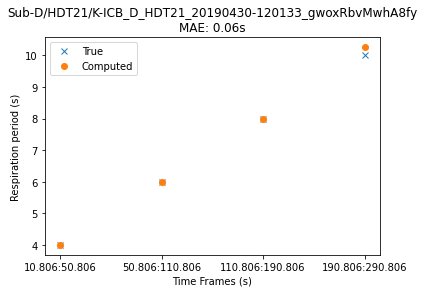

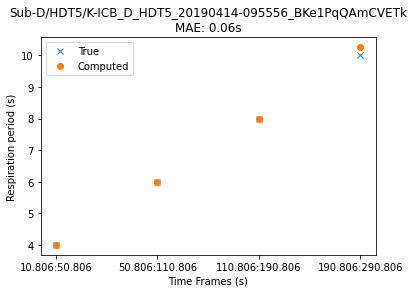

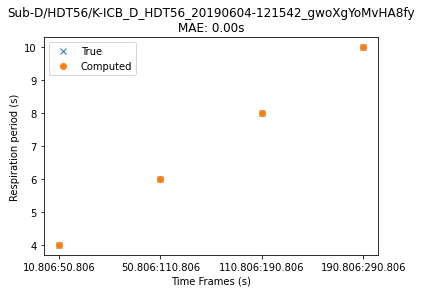

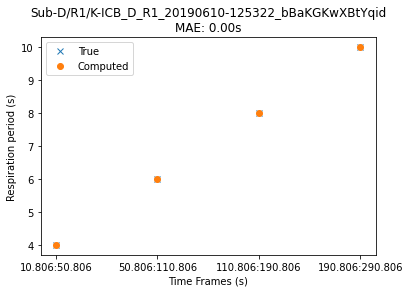

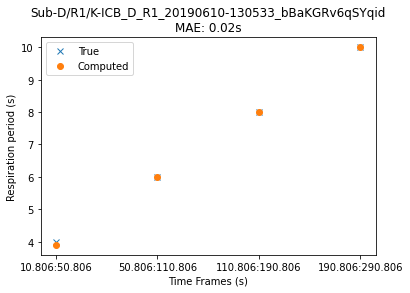

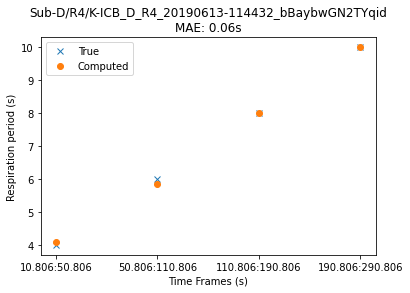

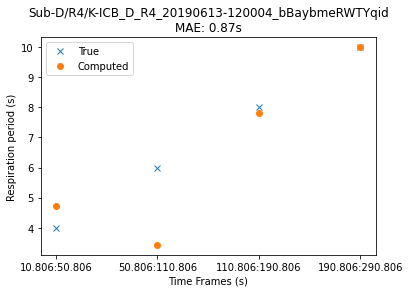

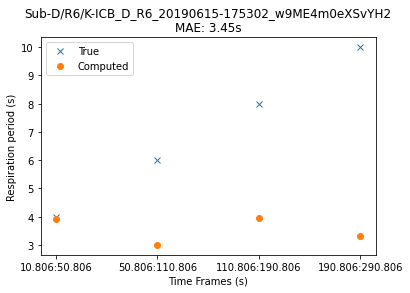

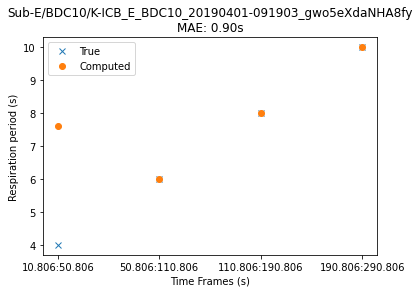

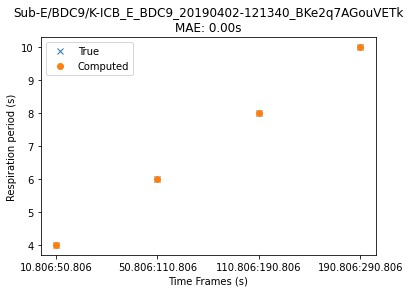

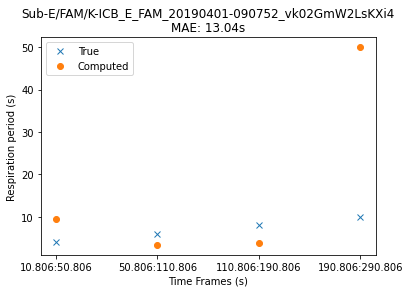

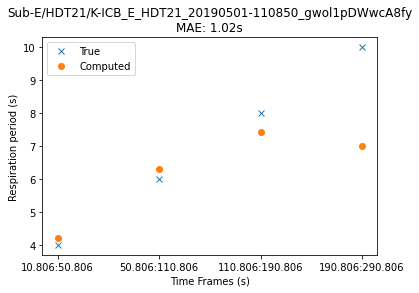

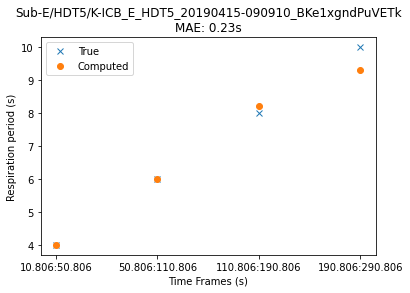

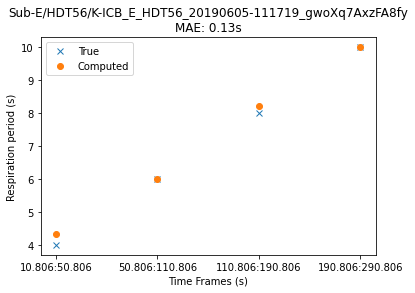

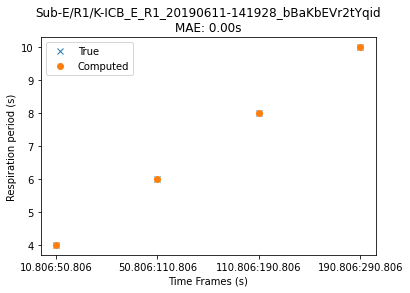

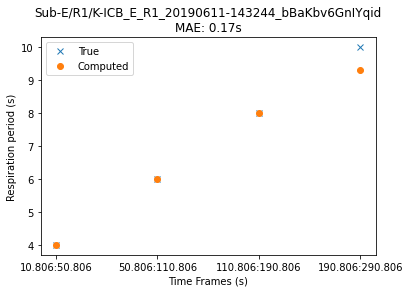

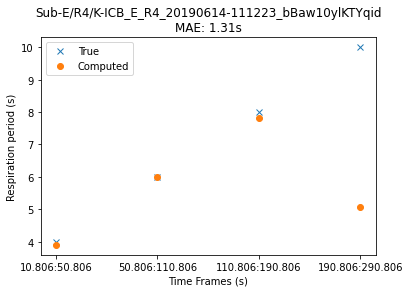

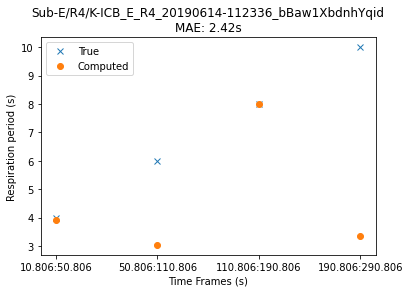

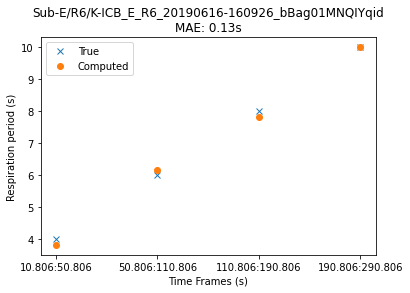

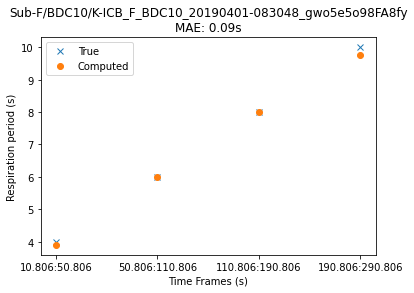

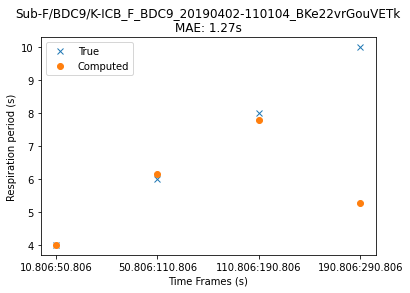

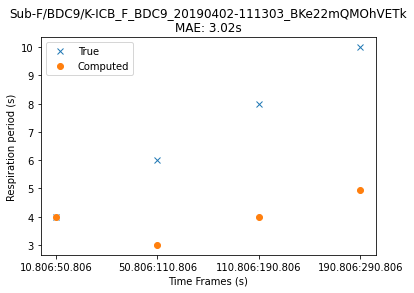

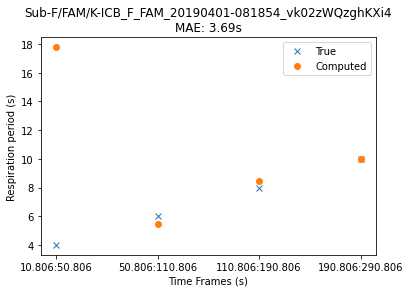

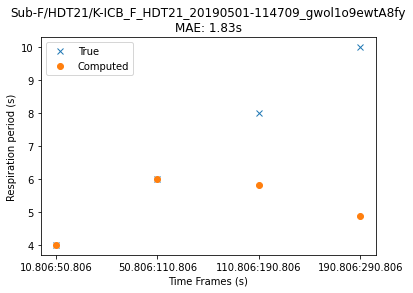

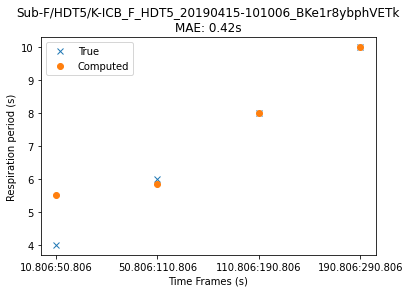

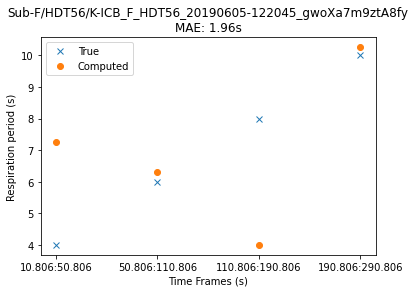

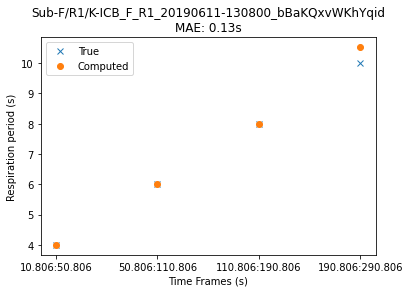

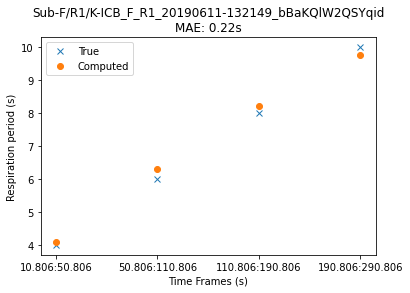

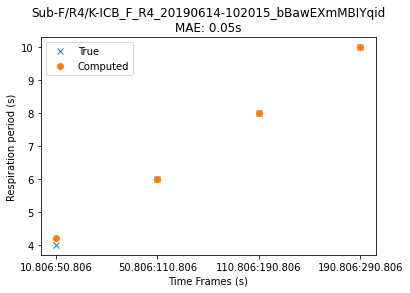

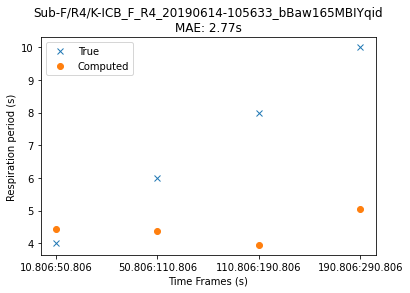

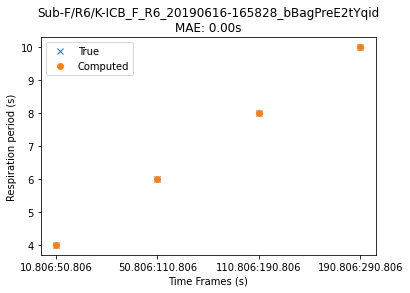

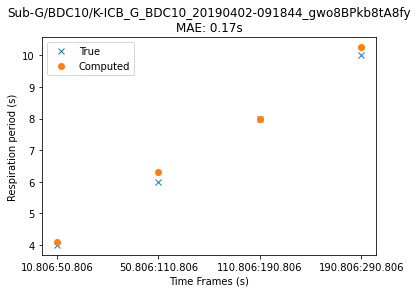

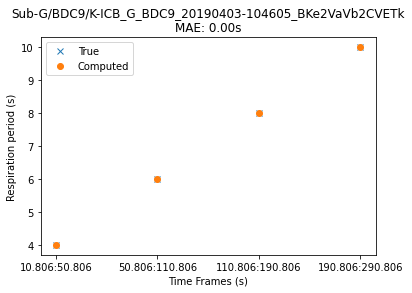

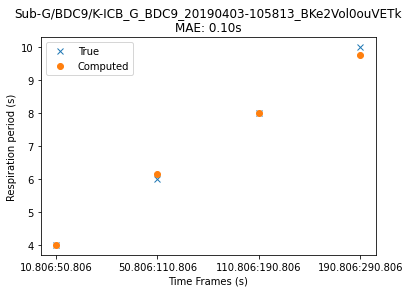

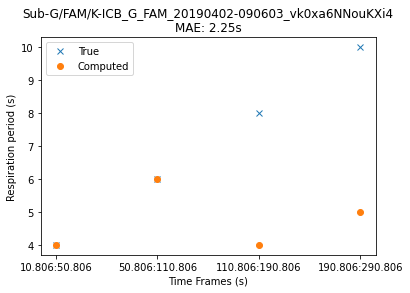

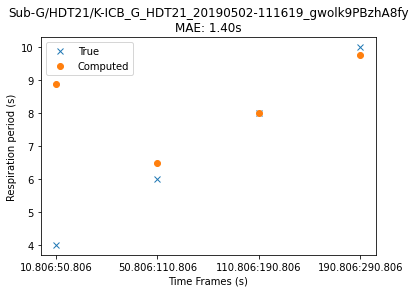

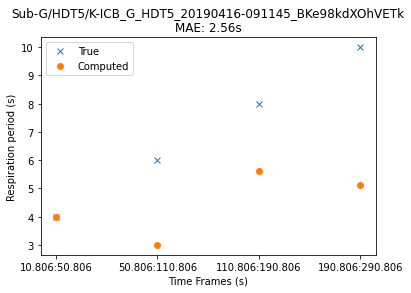

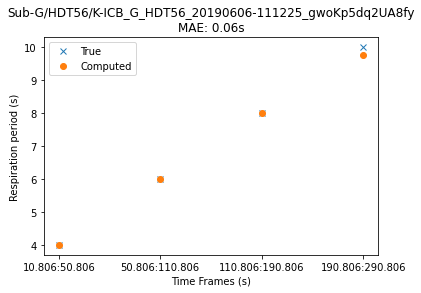

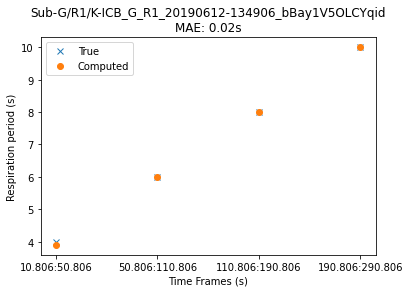

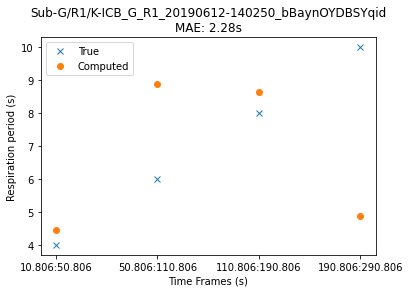

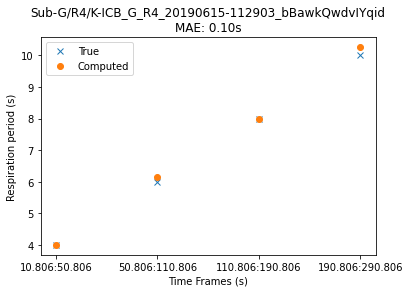

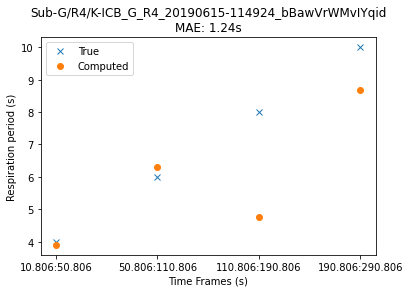

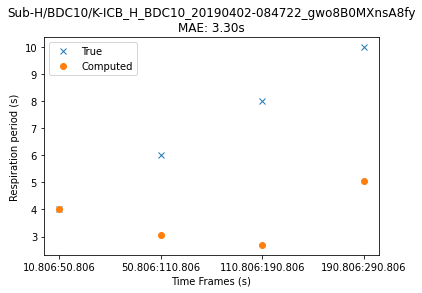

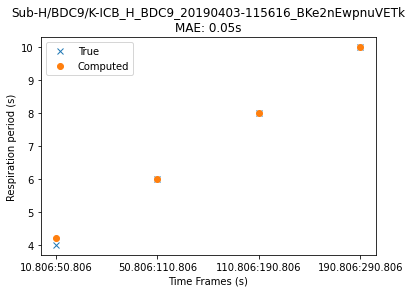

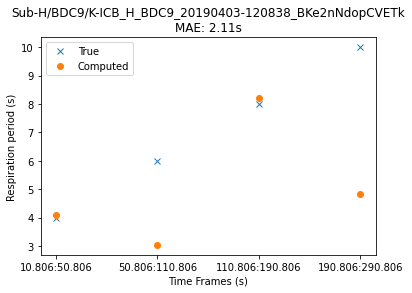

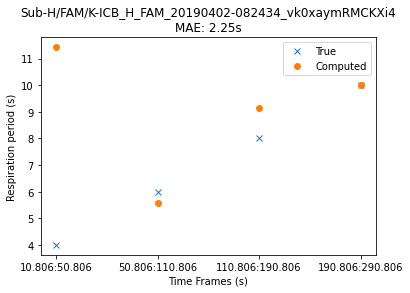

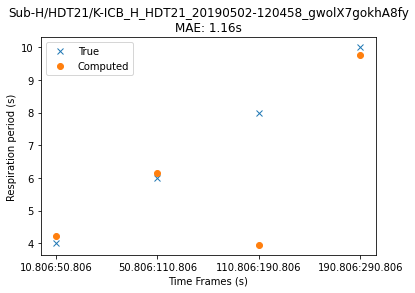

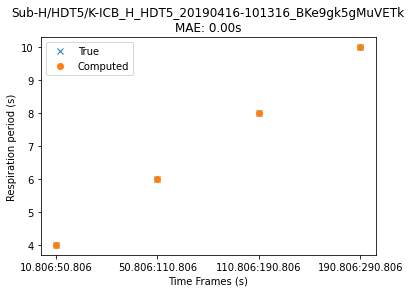

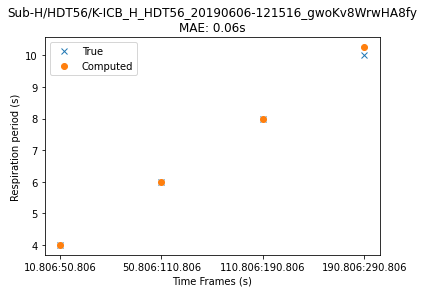

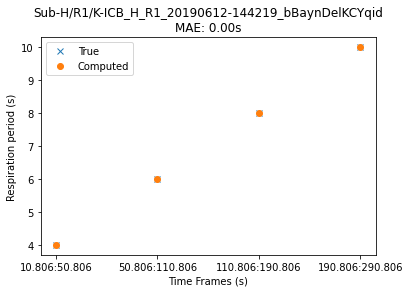

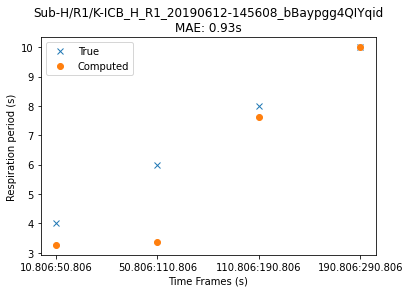

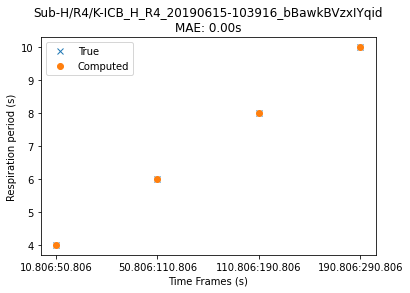

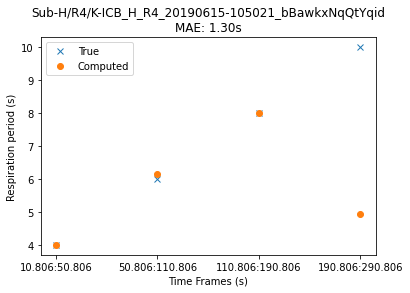

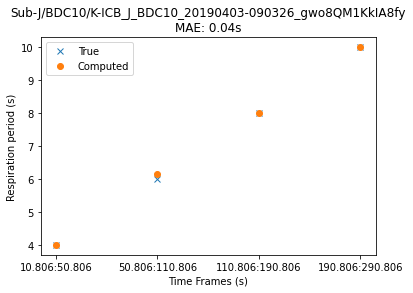

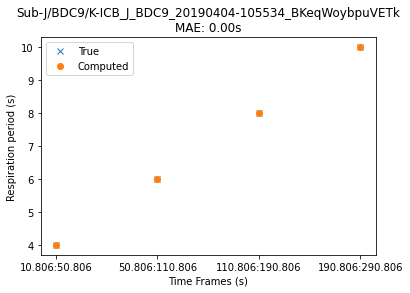

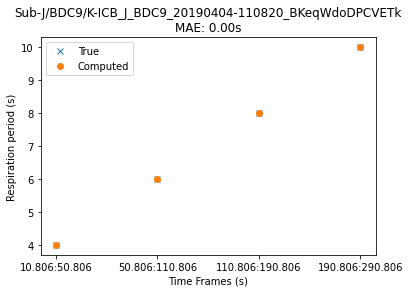

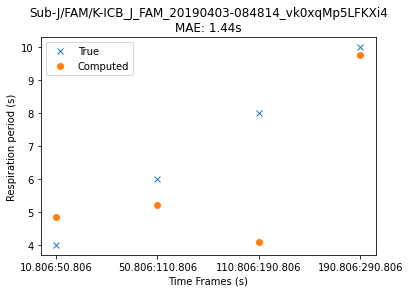

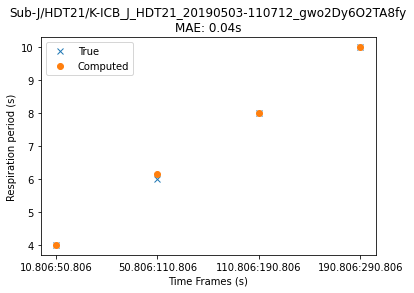

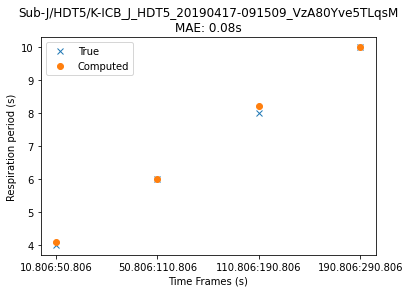

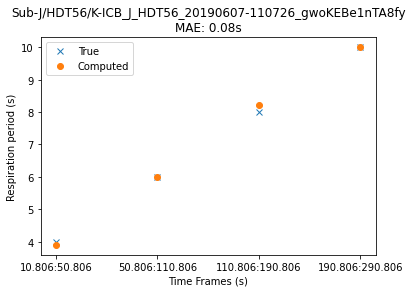

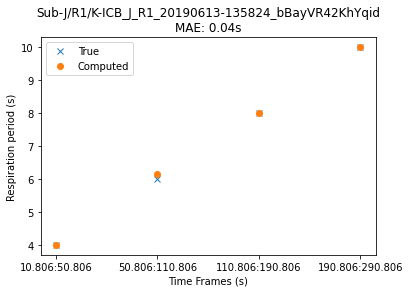

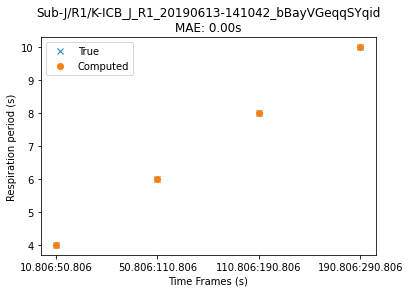

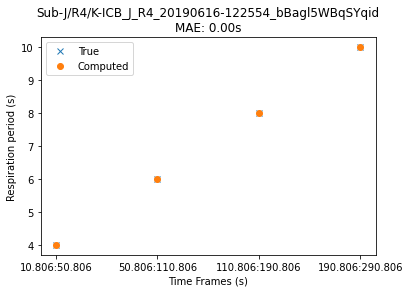

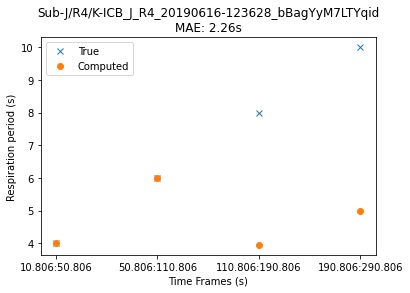

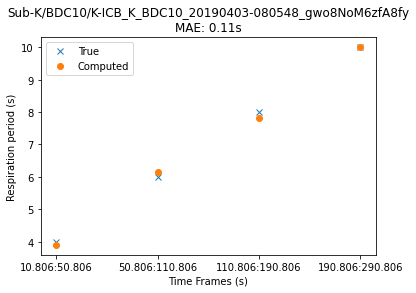

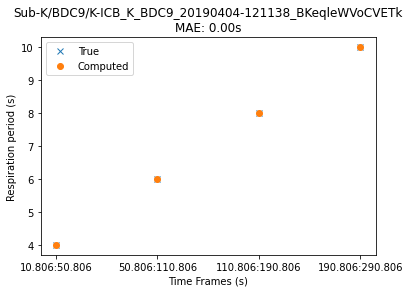

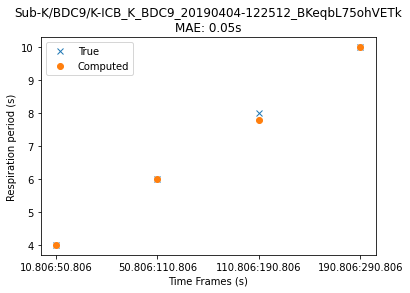

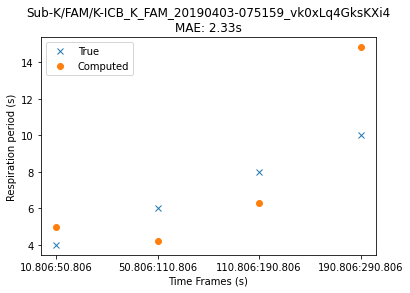

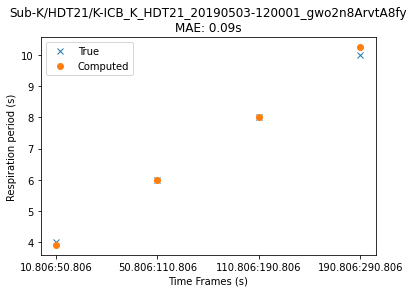

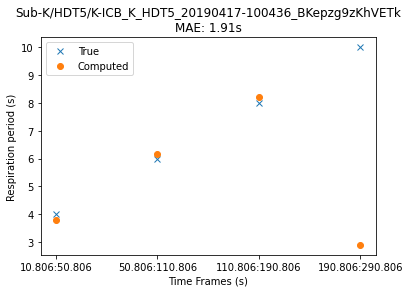

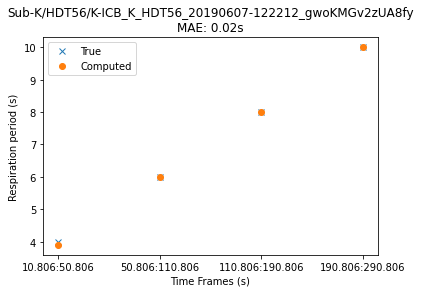

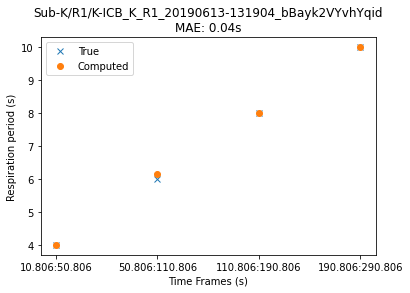

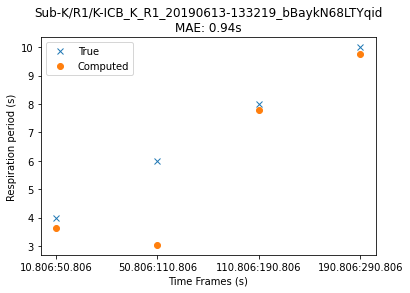

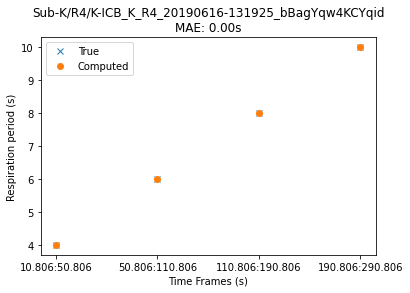

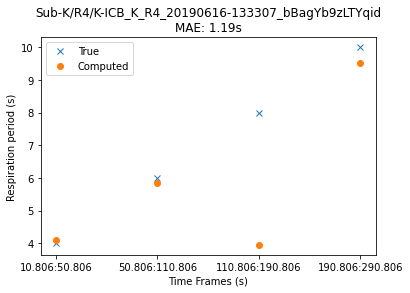

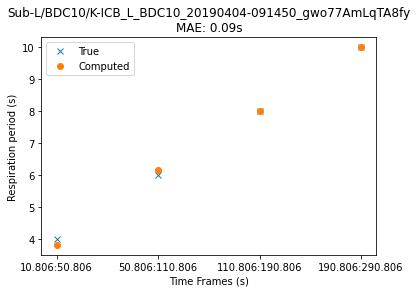

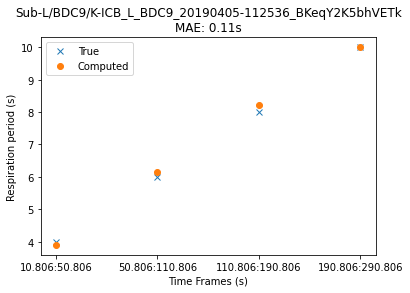

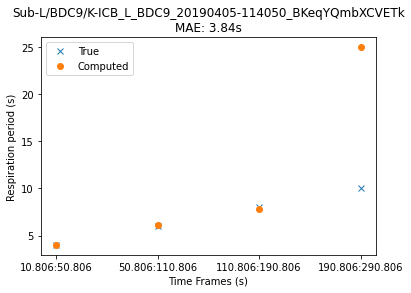

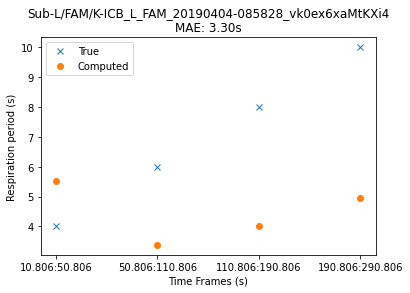

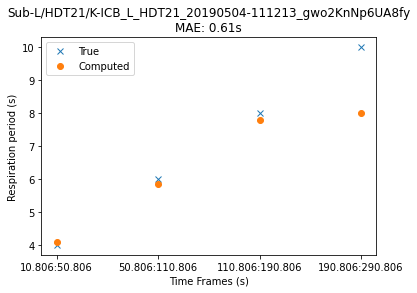

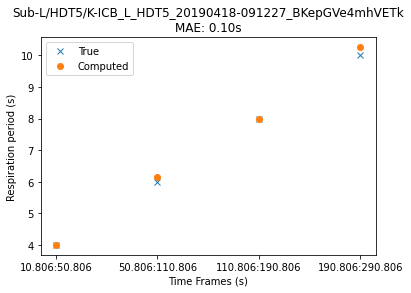

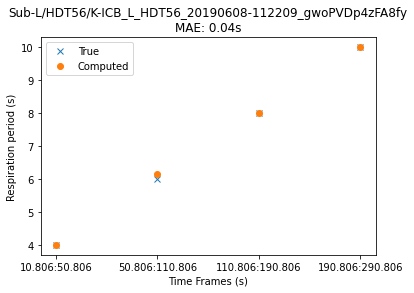

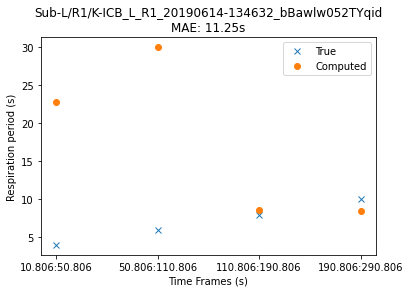

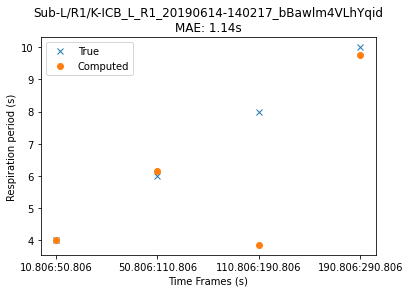

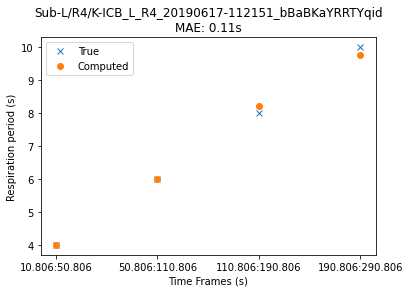

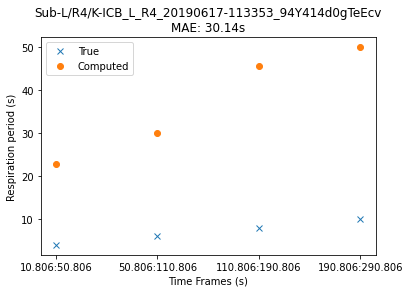

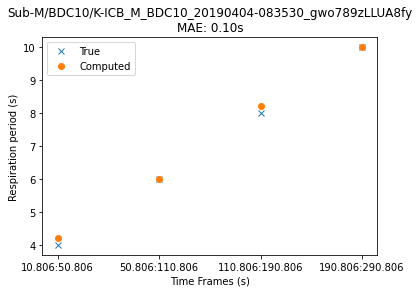

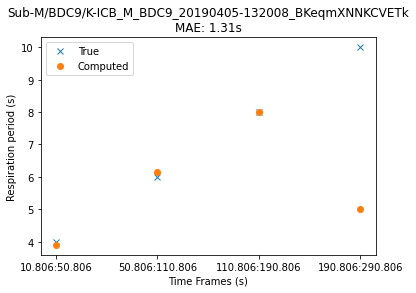

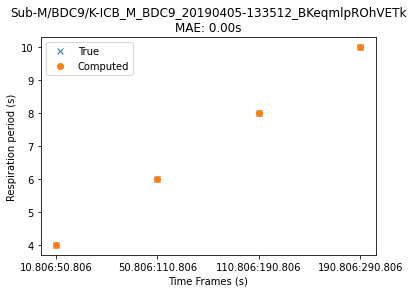

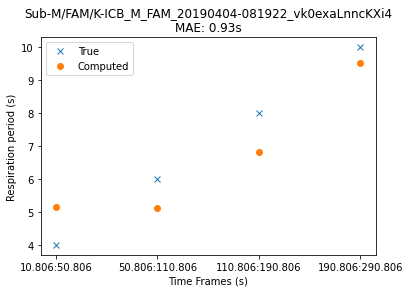

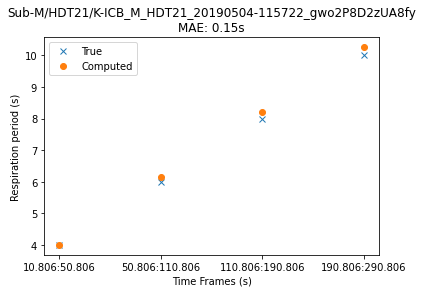

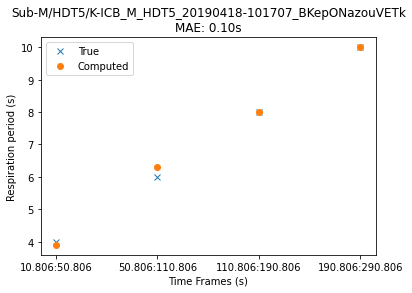

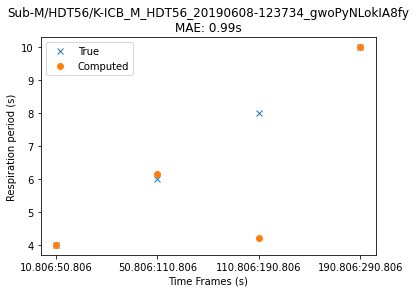

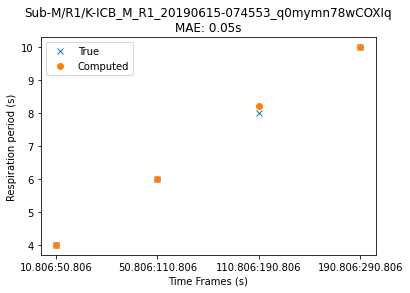

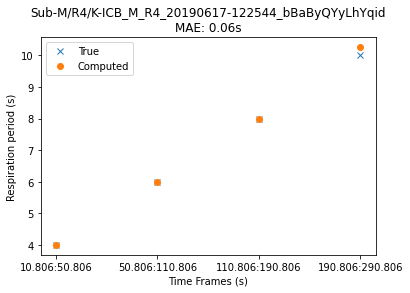

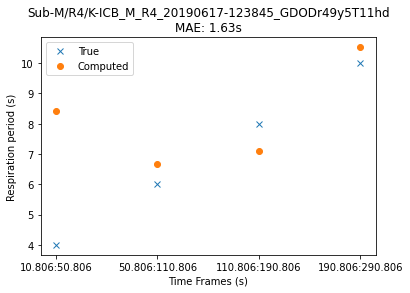

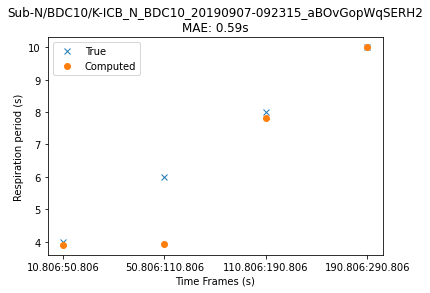

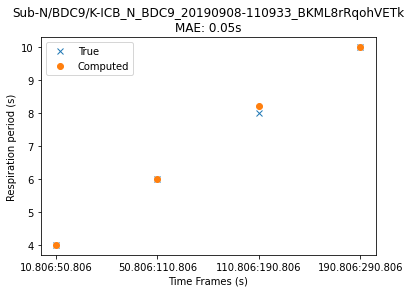

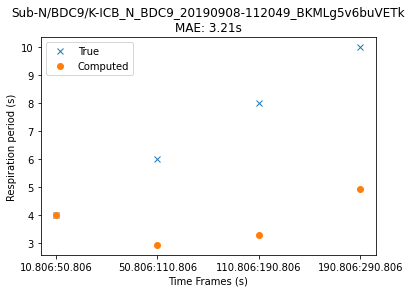

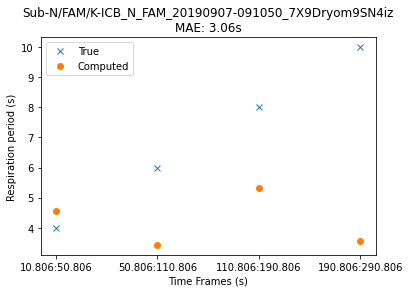

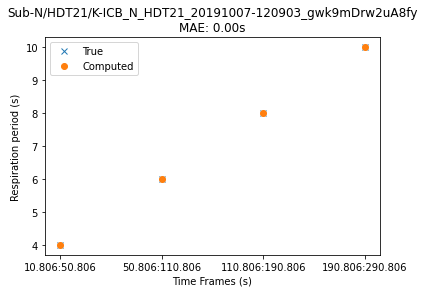

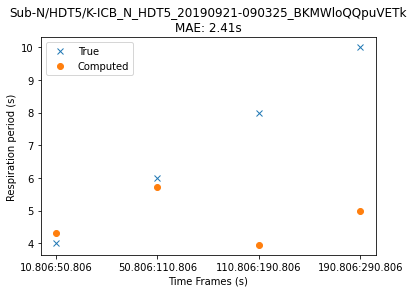

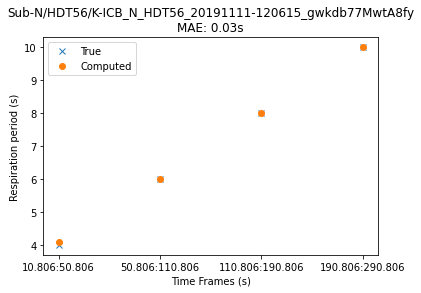

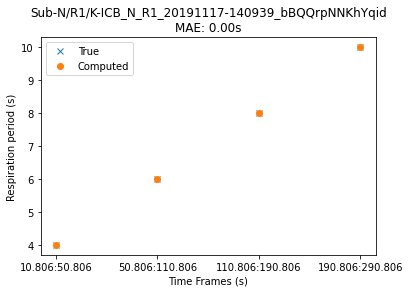

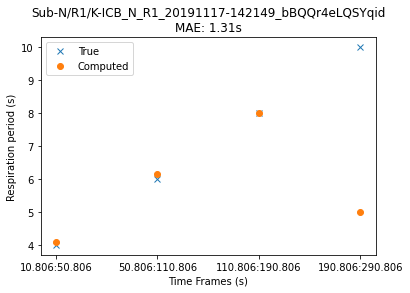

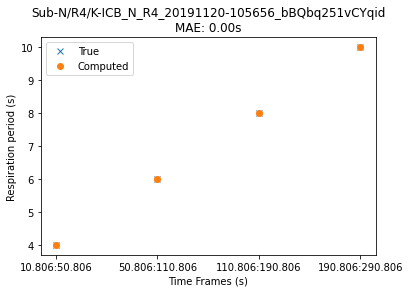

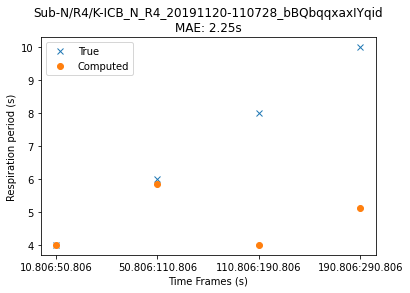

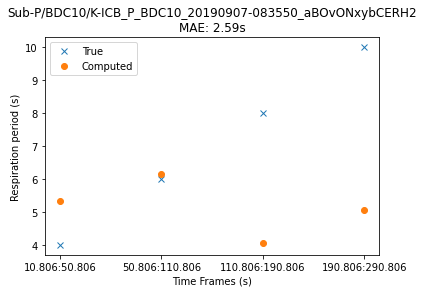

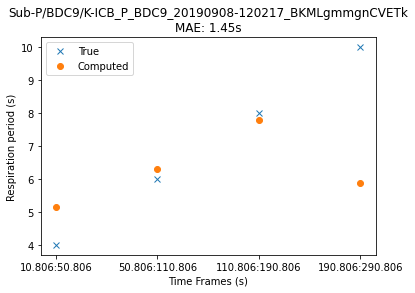

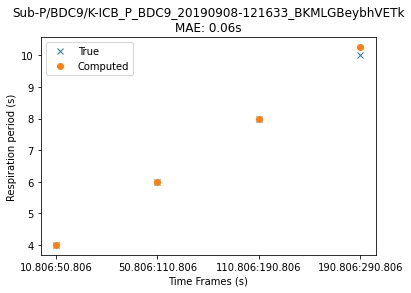

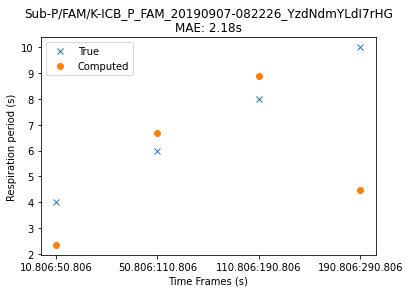

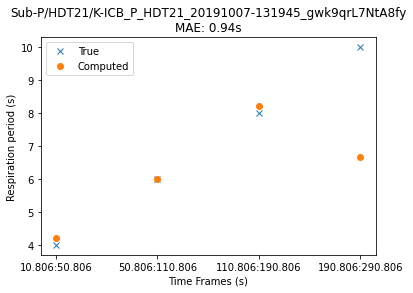

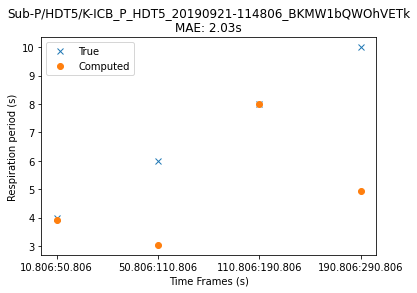

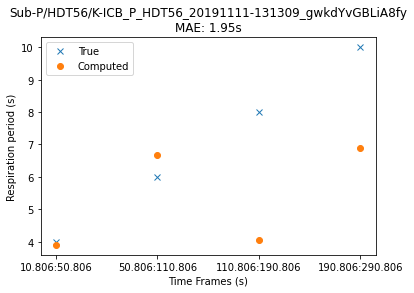

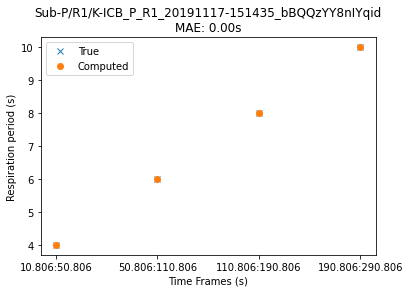

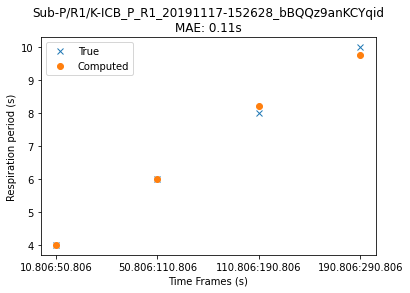

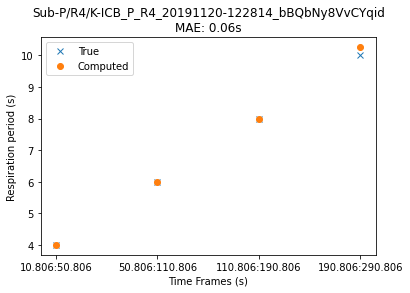

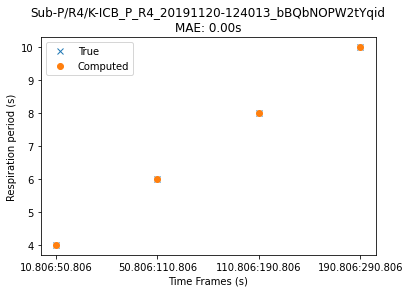

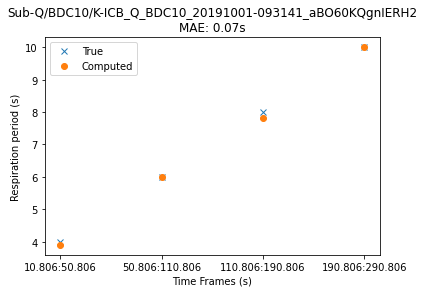

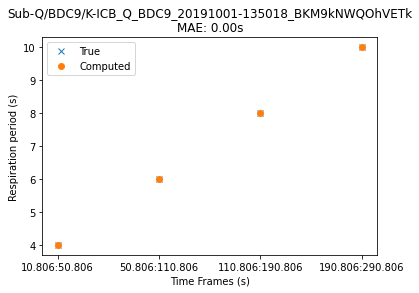

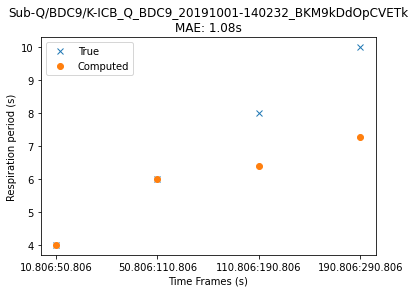

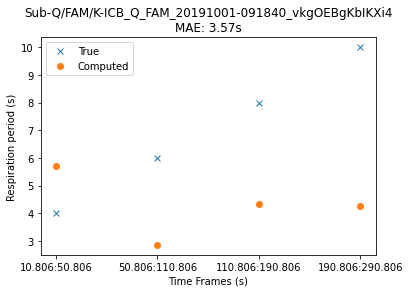

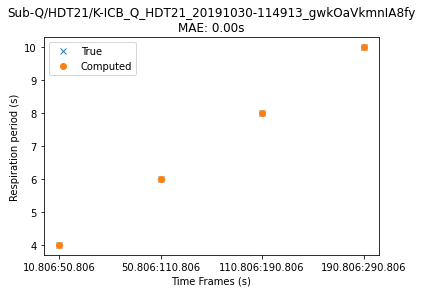

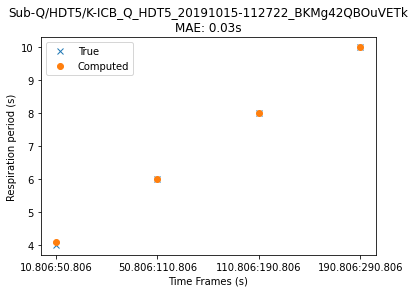

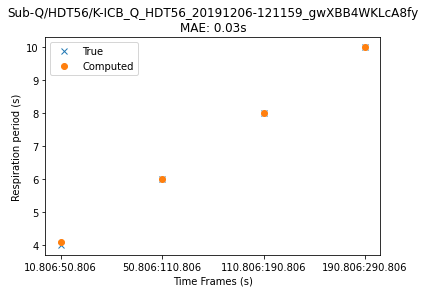

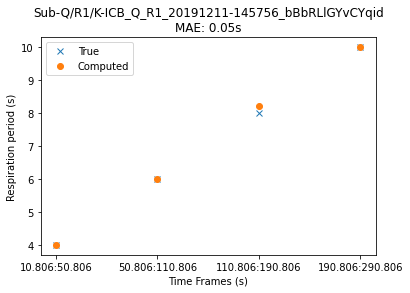

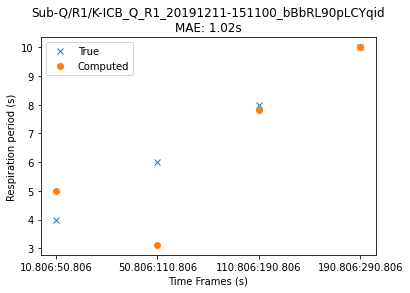

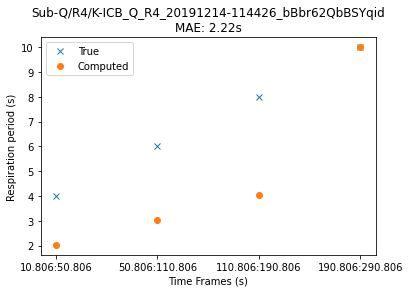

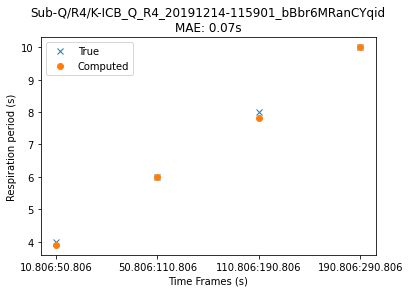

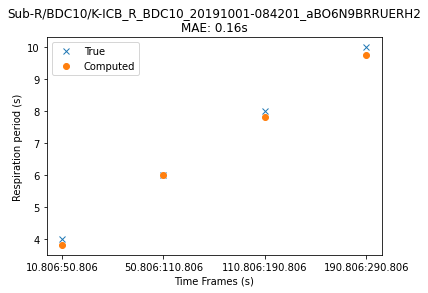

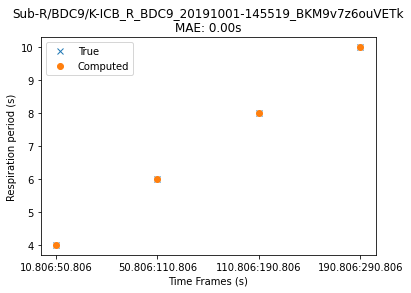

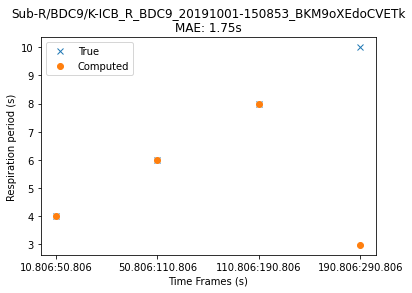

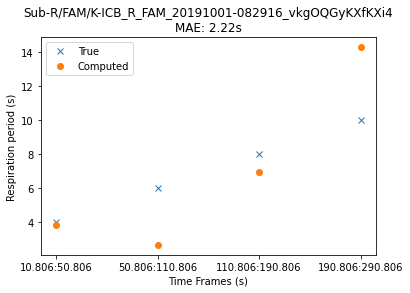

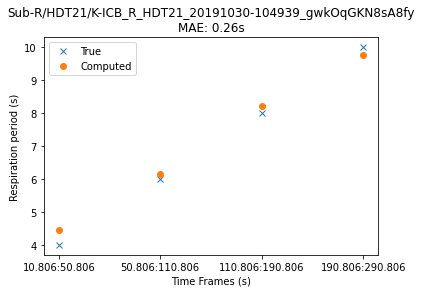

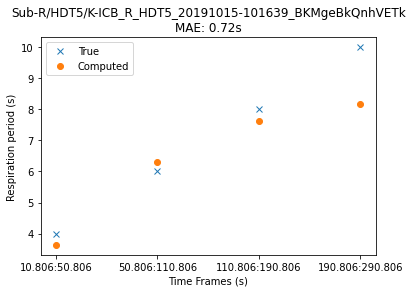

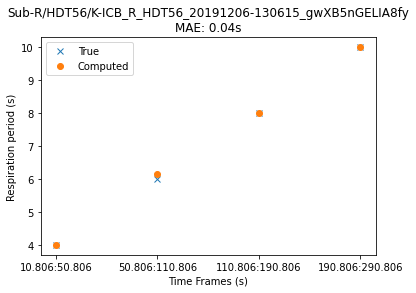

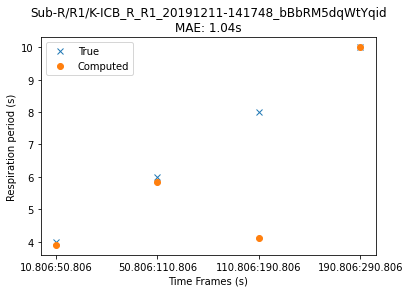

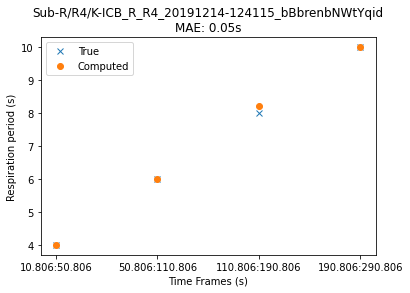

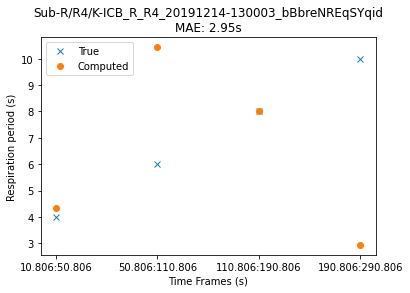

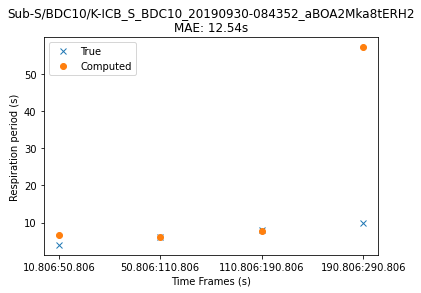

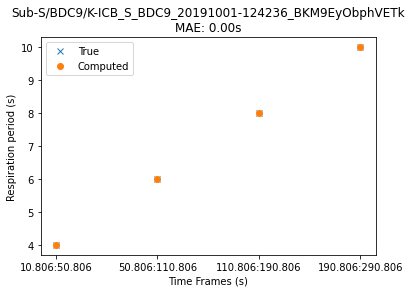

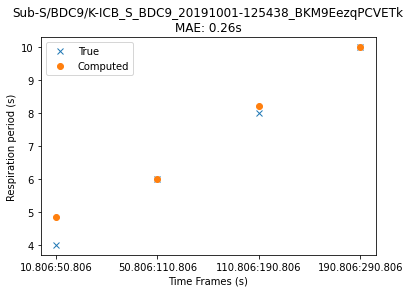

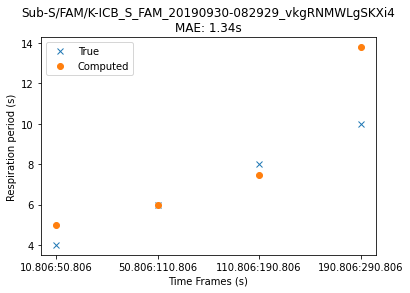

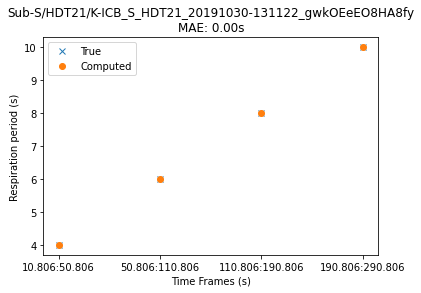

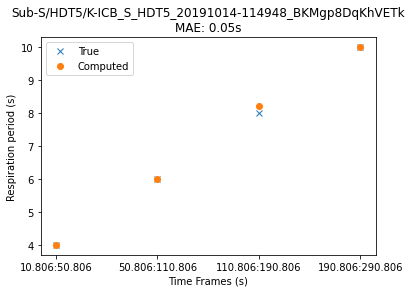

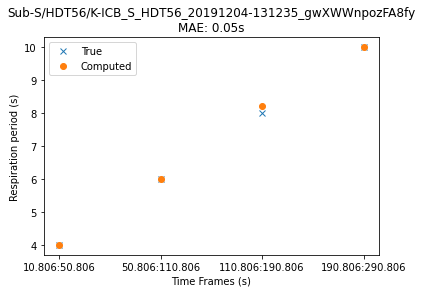

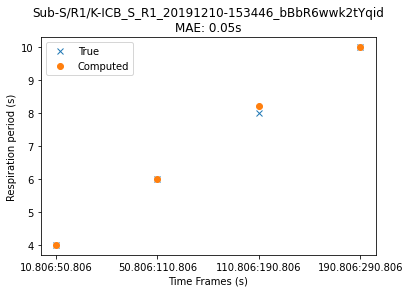

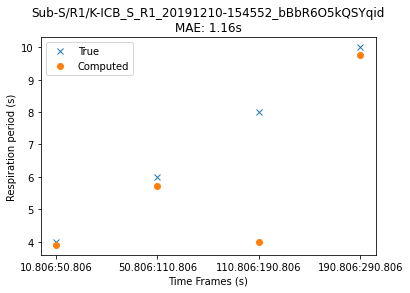

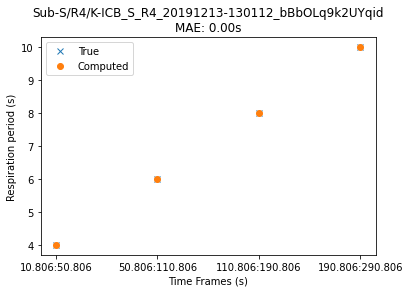

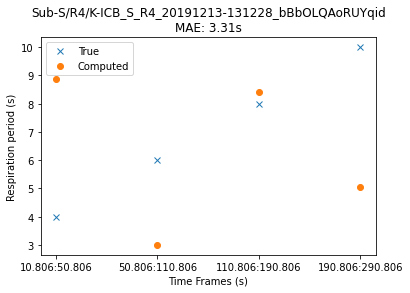

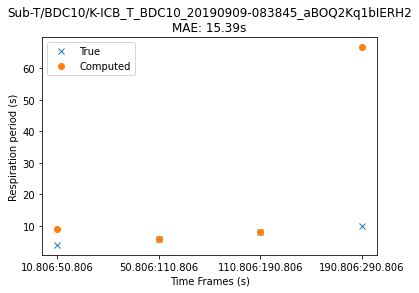

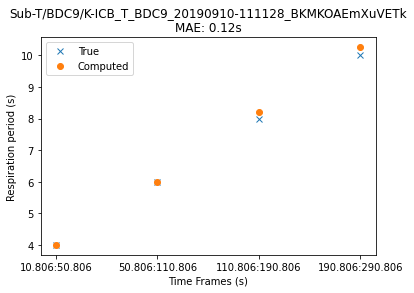

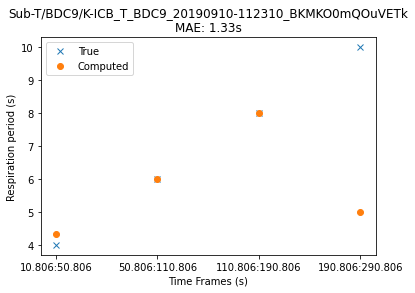

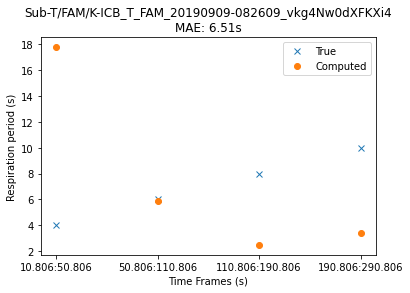

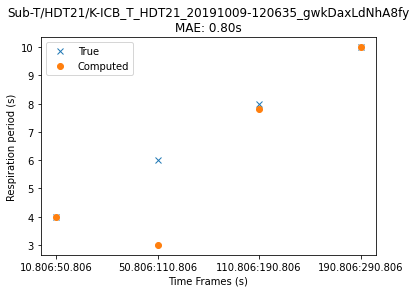

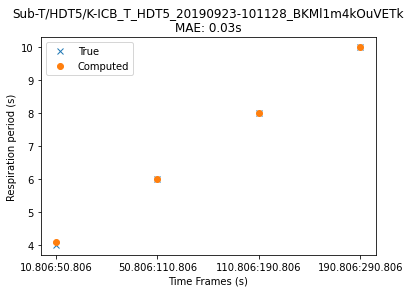

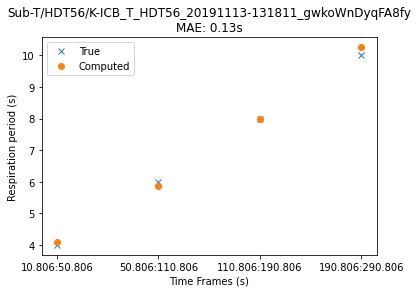

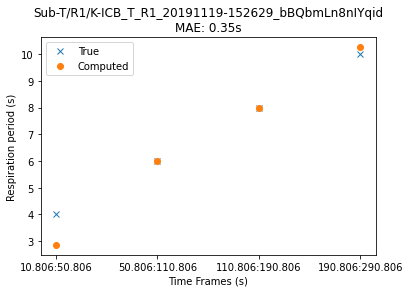

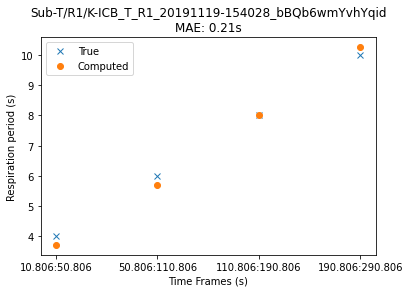

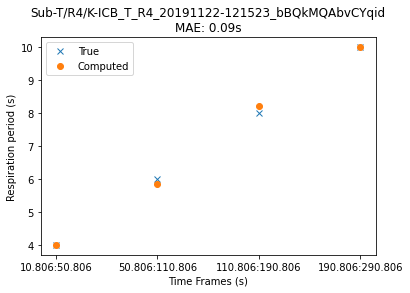

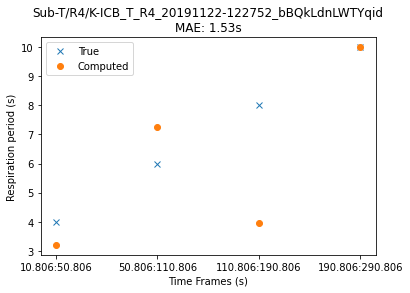

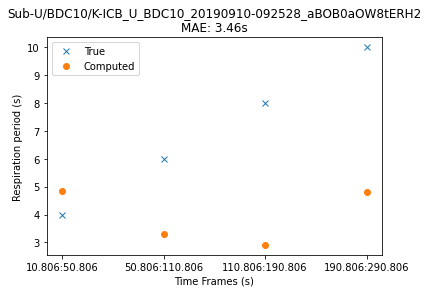

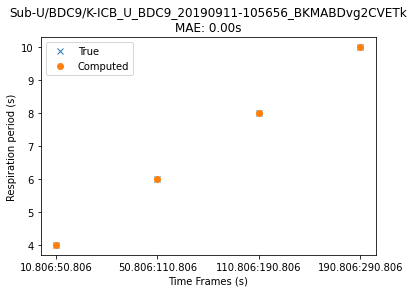

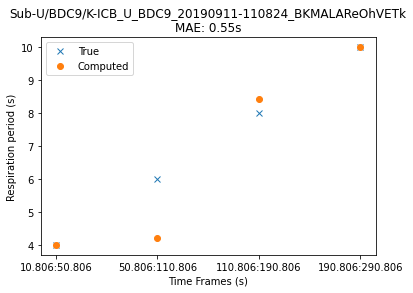

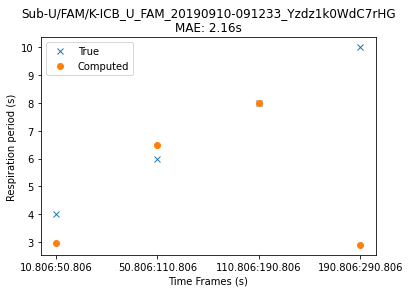

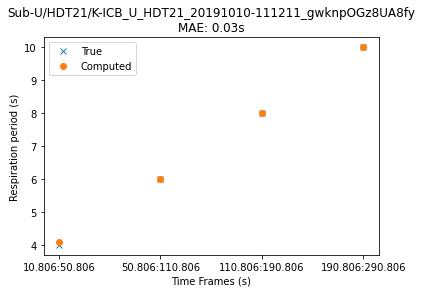

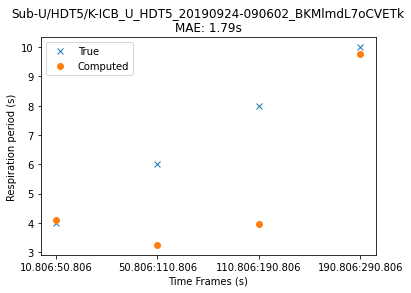

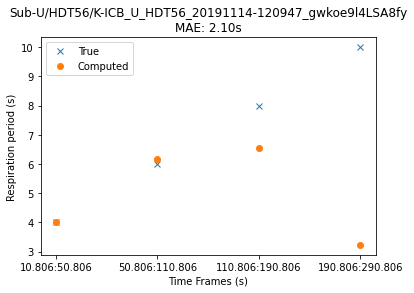

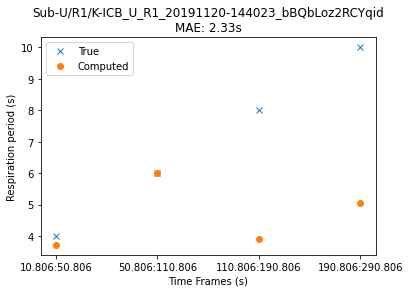

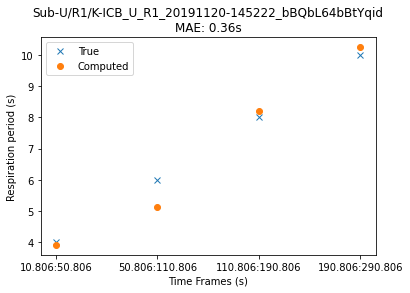

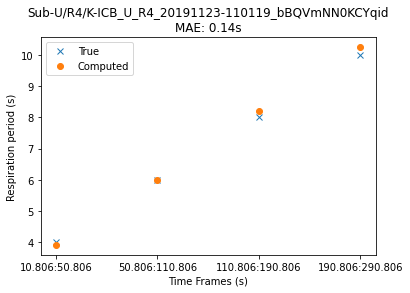

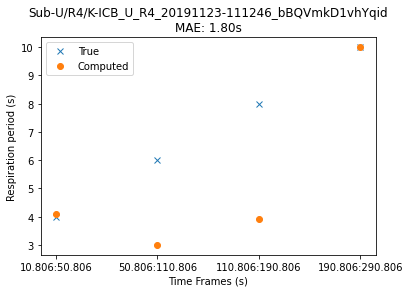

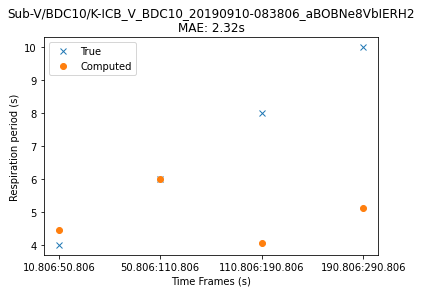

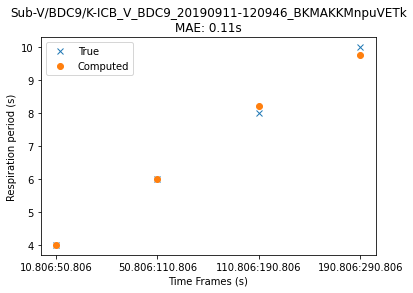

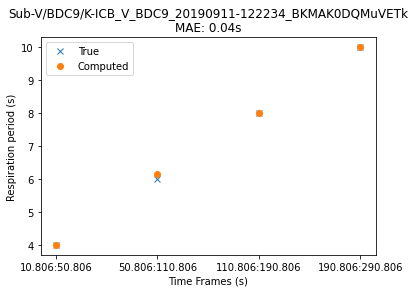

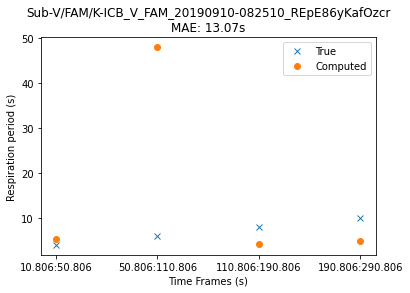

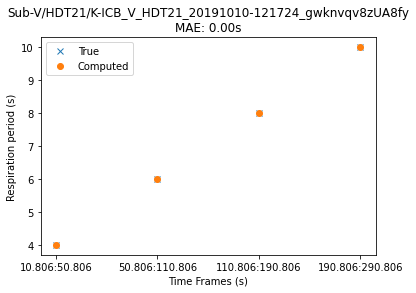

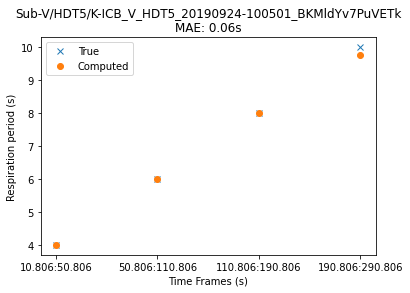

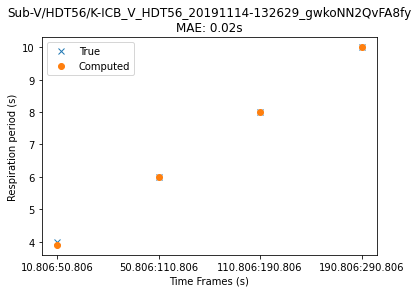

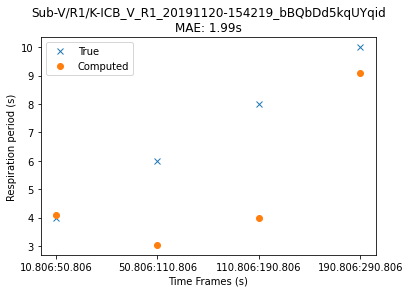

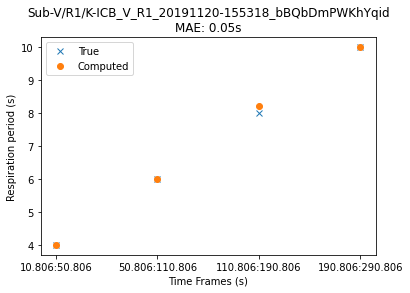

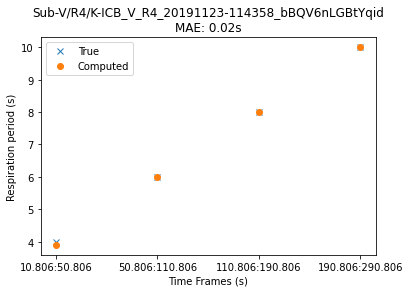

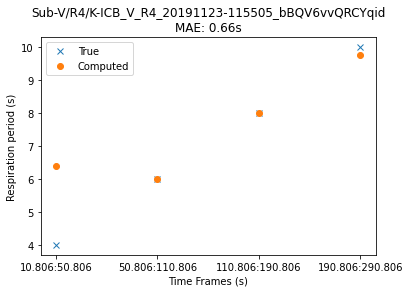

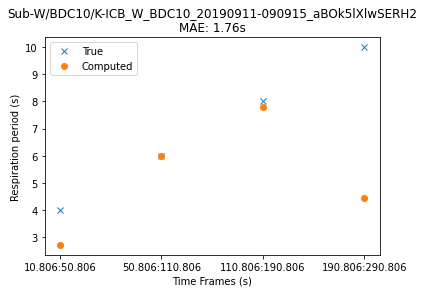

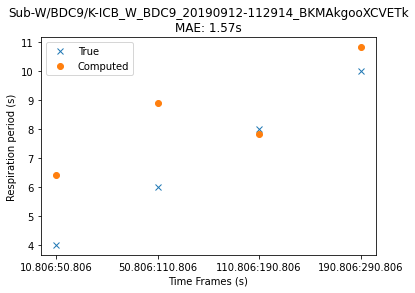

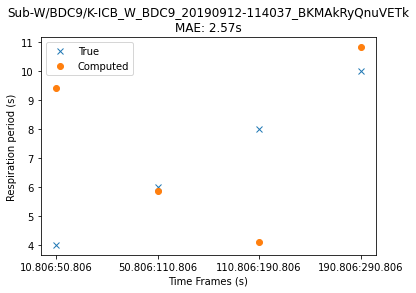

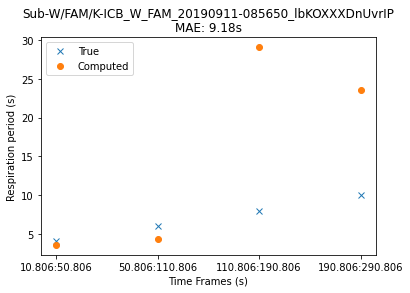

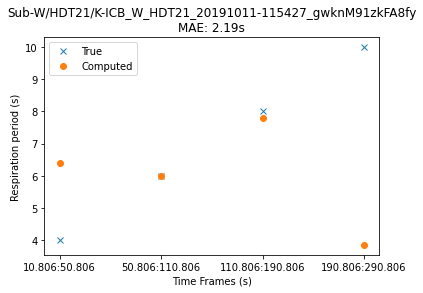

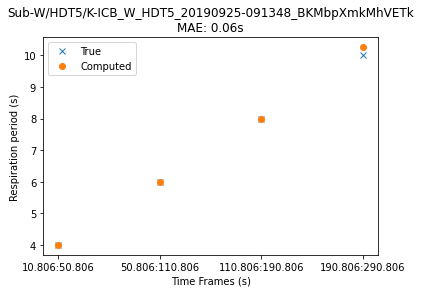

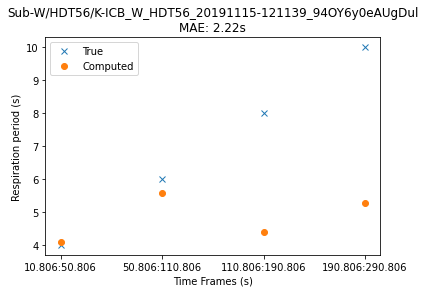

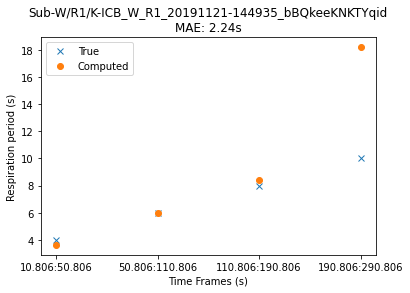

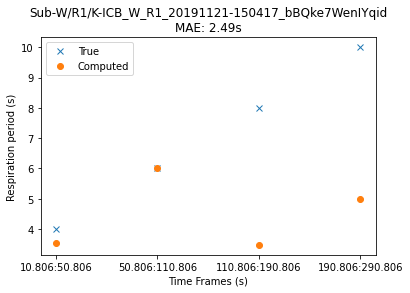

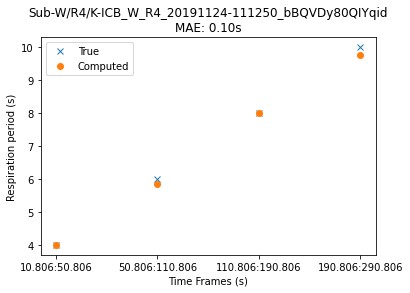

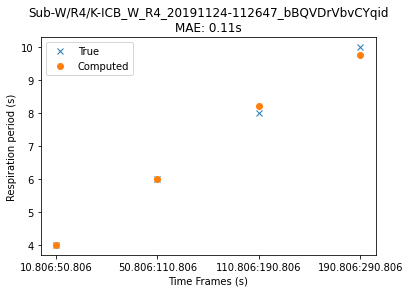

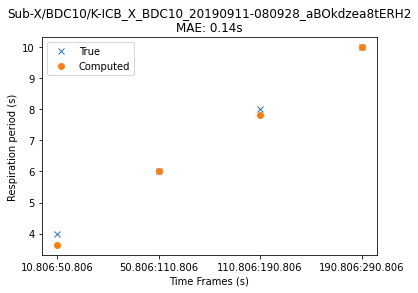

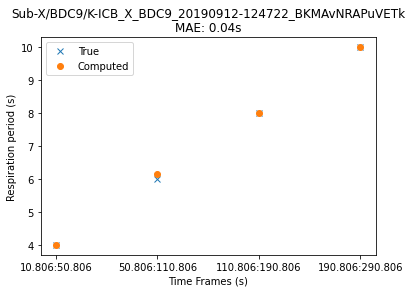

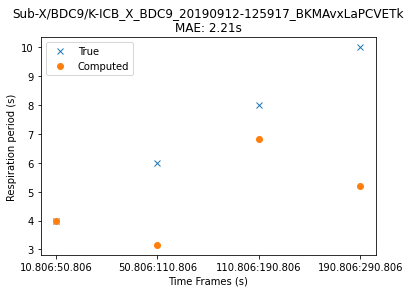

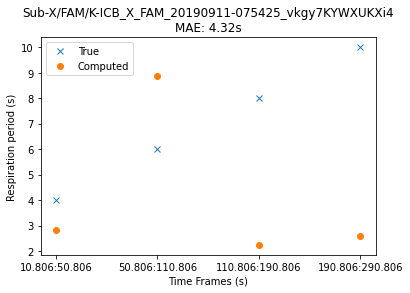

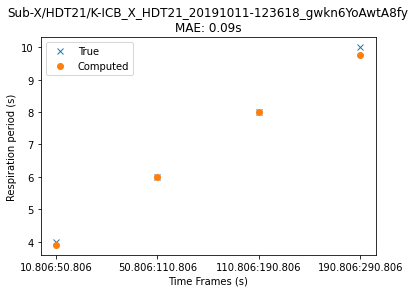

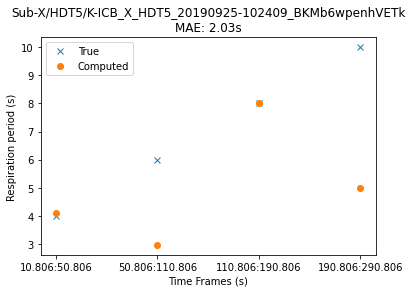

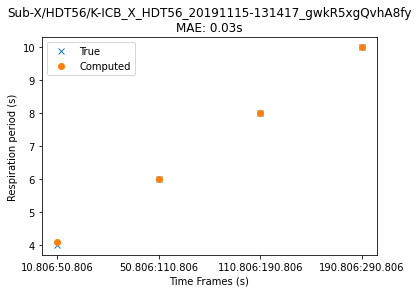

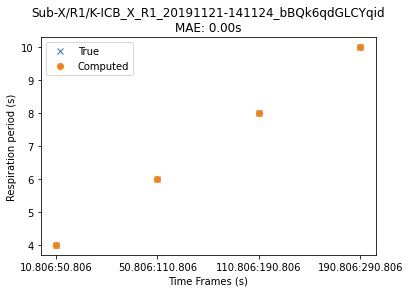

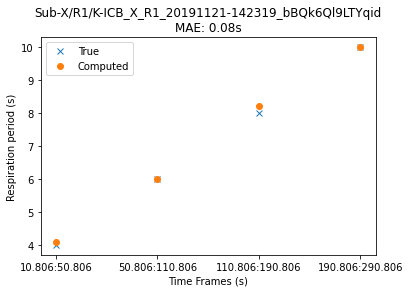

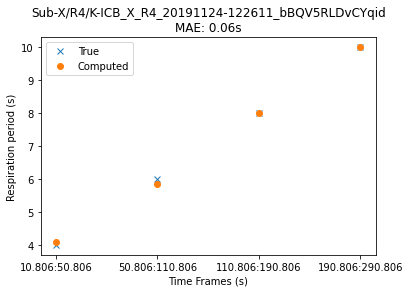

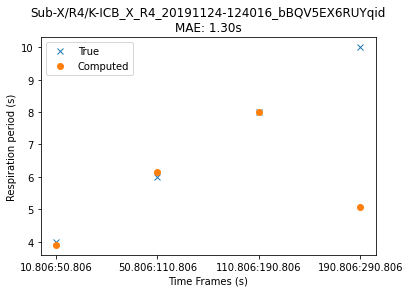

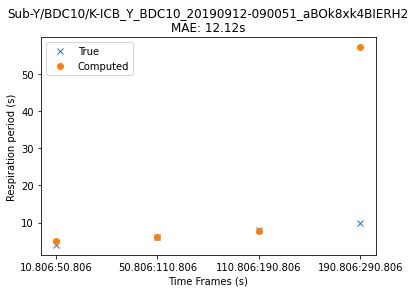

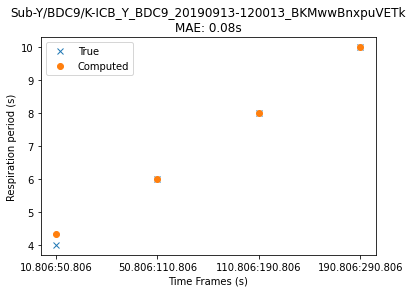

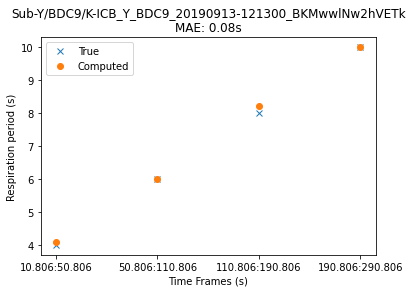

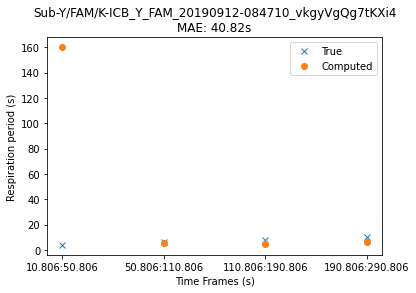

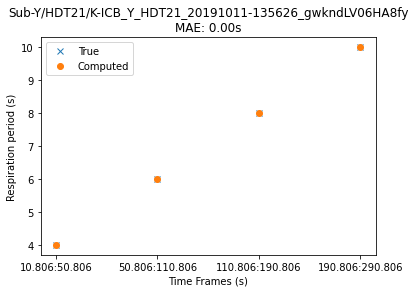

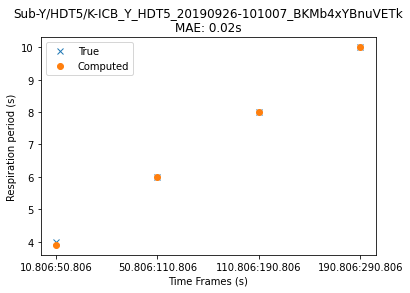

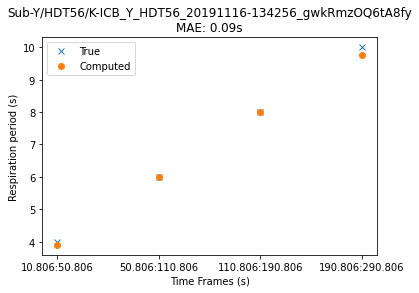

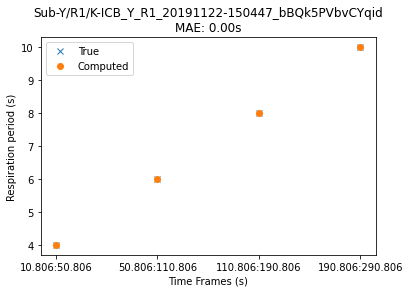

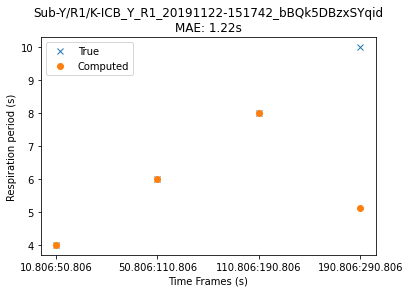

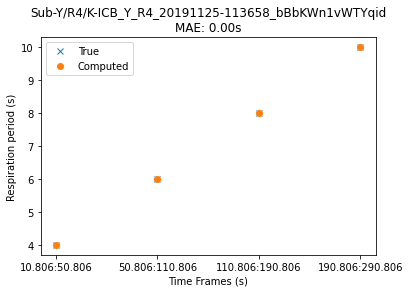

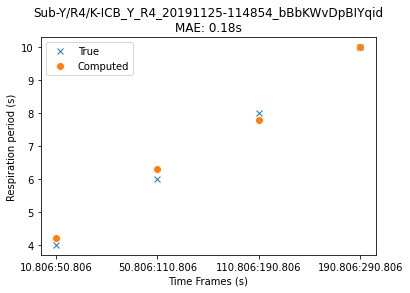

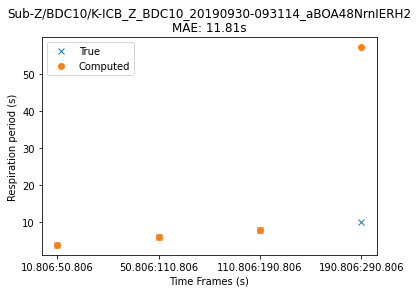

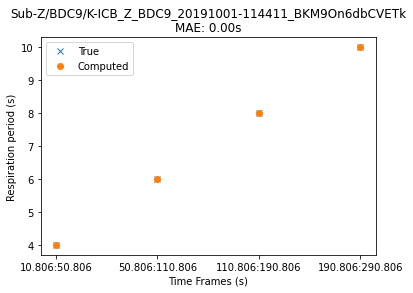

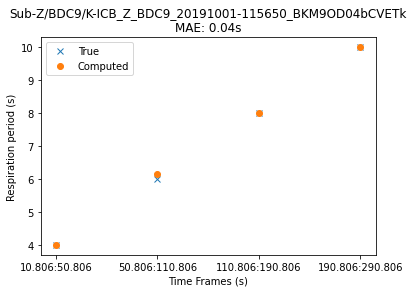

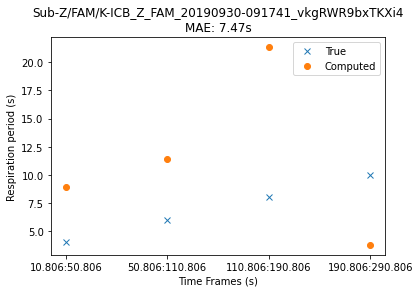

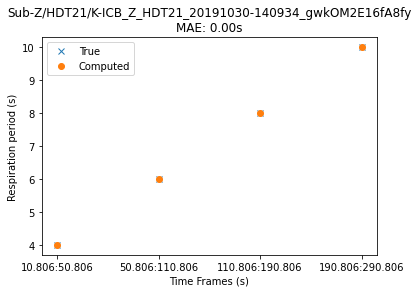

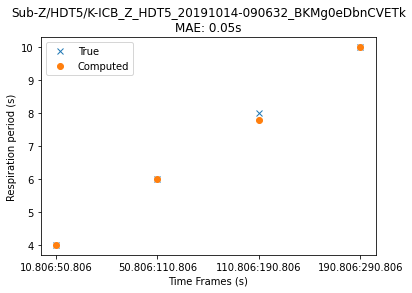

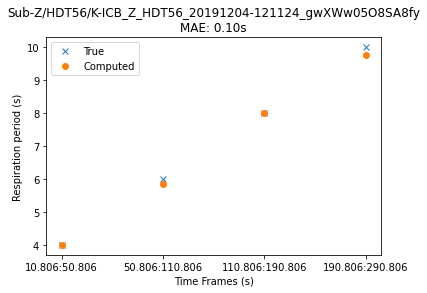

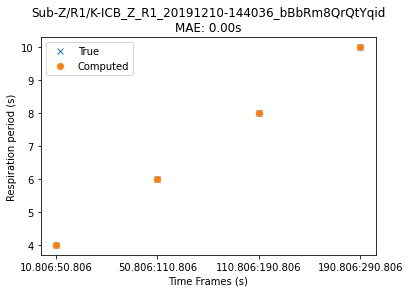

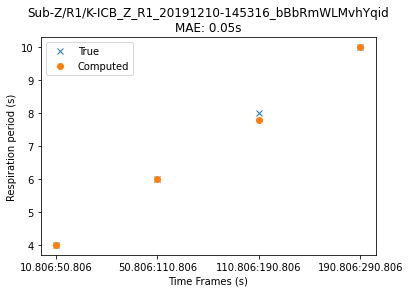

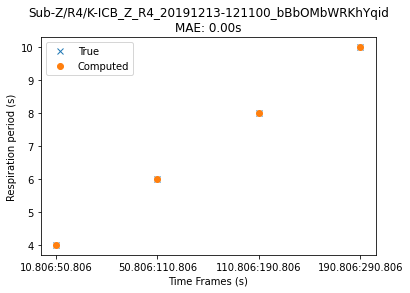

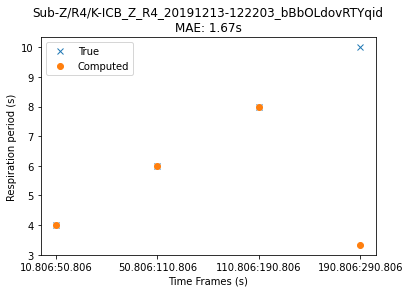

In [24]:
order = 200
kernel_t = 1
distance_ms = 1000
prominence = 0.25

sec_path_all = []
err_all = []

for idx, i in enumerate(path_all):
    print(idx)
    record = read_record(i)
    scg = record.signals["scg"]
    s6 = detrend(scg.vel[1][:,2])
    resp = moving_average_simple(s6, order)
    kernel_smp = kernel_t*fs  
    resp = medfilt(resp, int(kernel_smp)+1)
    resp = nk.rsp.rsp_clean(resp)
    resp = detrend(resp)
    resp = scale_normalization(resp, rg=(-1, 1))
    resp = scale_standardization_robust(resp)
    resp = _correct_rsp_sign(resp, fs, distance_ms=distance_ms, prominence=prominence)
    resp_period_all_comp = []
    for k in time_frames:
        resp_cut = resp[int(k[0]*fs):int(k[1]*fs)]
        fpcntile, mpf, fmax, Ptotal, f, P = psd2(resp_cut-np.mean(resp_cut), fs=fs, nfft=8*np.ceil(len(resp_cut)/2), show=False)
        resp_period = 1/fmax
        resp_period_all_comp.append(resp_period)  
    main_path = os.path.normpath(i)
    sec_path = main_path.split(os.sep)
    sec_path = sec_path[7]+'/'+sec_path[8]+'/'+sec_path[9]
    sec_path_all.append(sec_path)
    resp_period_all_true = [4, 6, 8, 10]
    err = mean_absolute_error(resp_period_all_true, resp_period_all_comp)
    err_all.append(err)
    plt.figure()
    x = np.array([0,1,2,3])
    my_xticks = ['10.806:50.806','50.806:110.806','110.806:190.806','190.806:290.806']
    plt.xticks(x, my_xticks)
    plt.plot(my_xticks, resp_period_all_true, 'x')
    plt.plot(my_xticks, resp_period_all_comp, 'o')
    plt.xlabel('Time Frames (s)')
    plt.ylabel("Respiration period (s)")
    plt.legend(['True', 'Computed'])
    plt.title(sec_path+ '\nMAE: ' +str(format(err, ".2f"))+ 's')

Text(0, 0.5, 'MAE (s)')

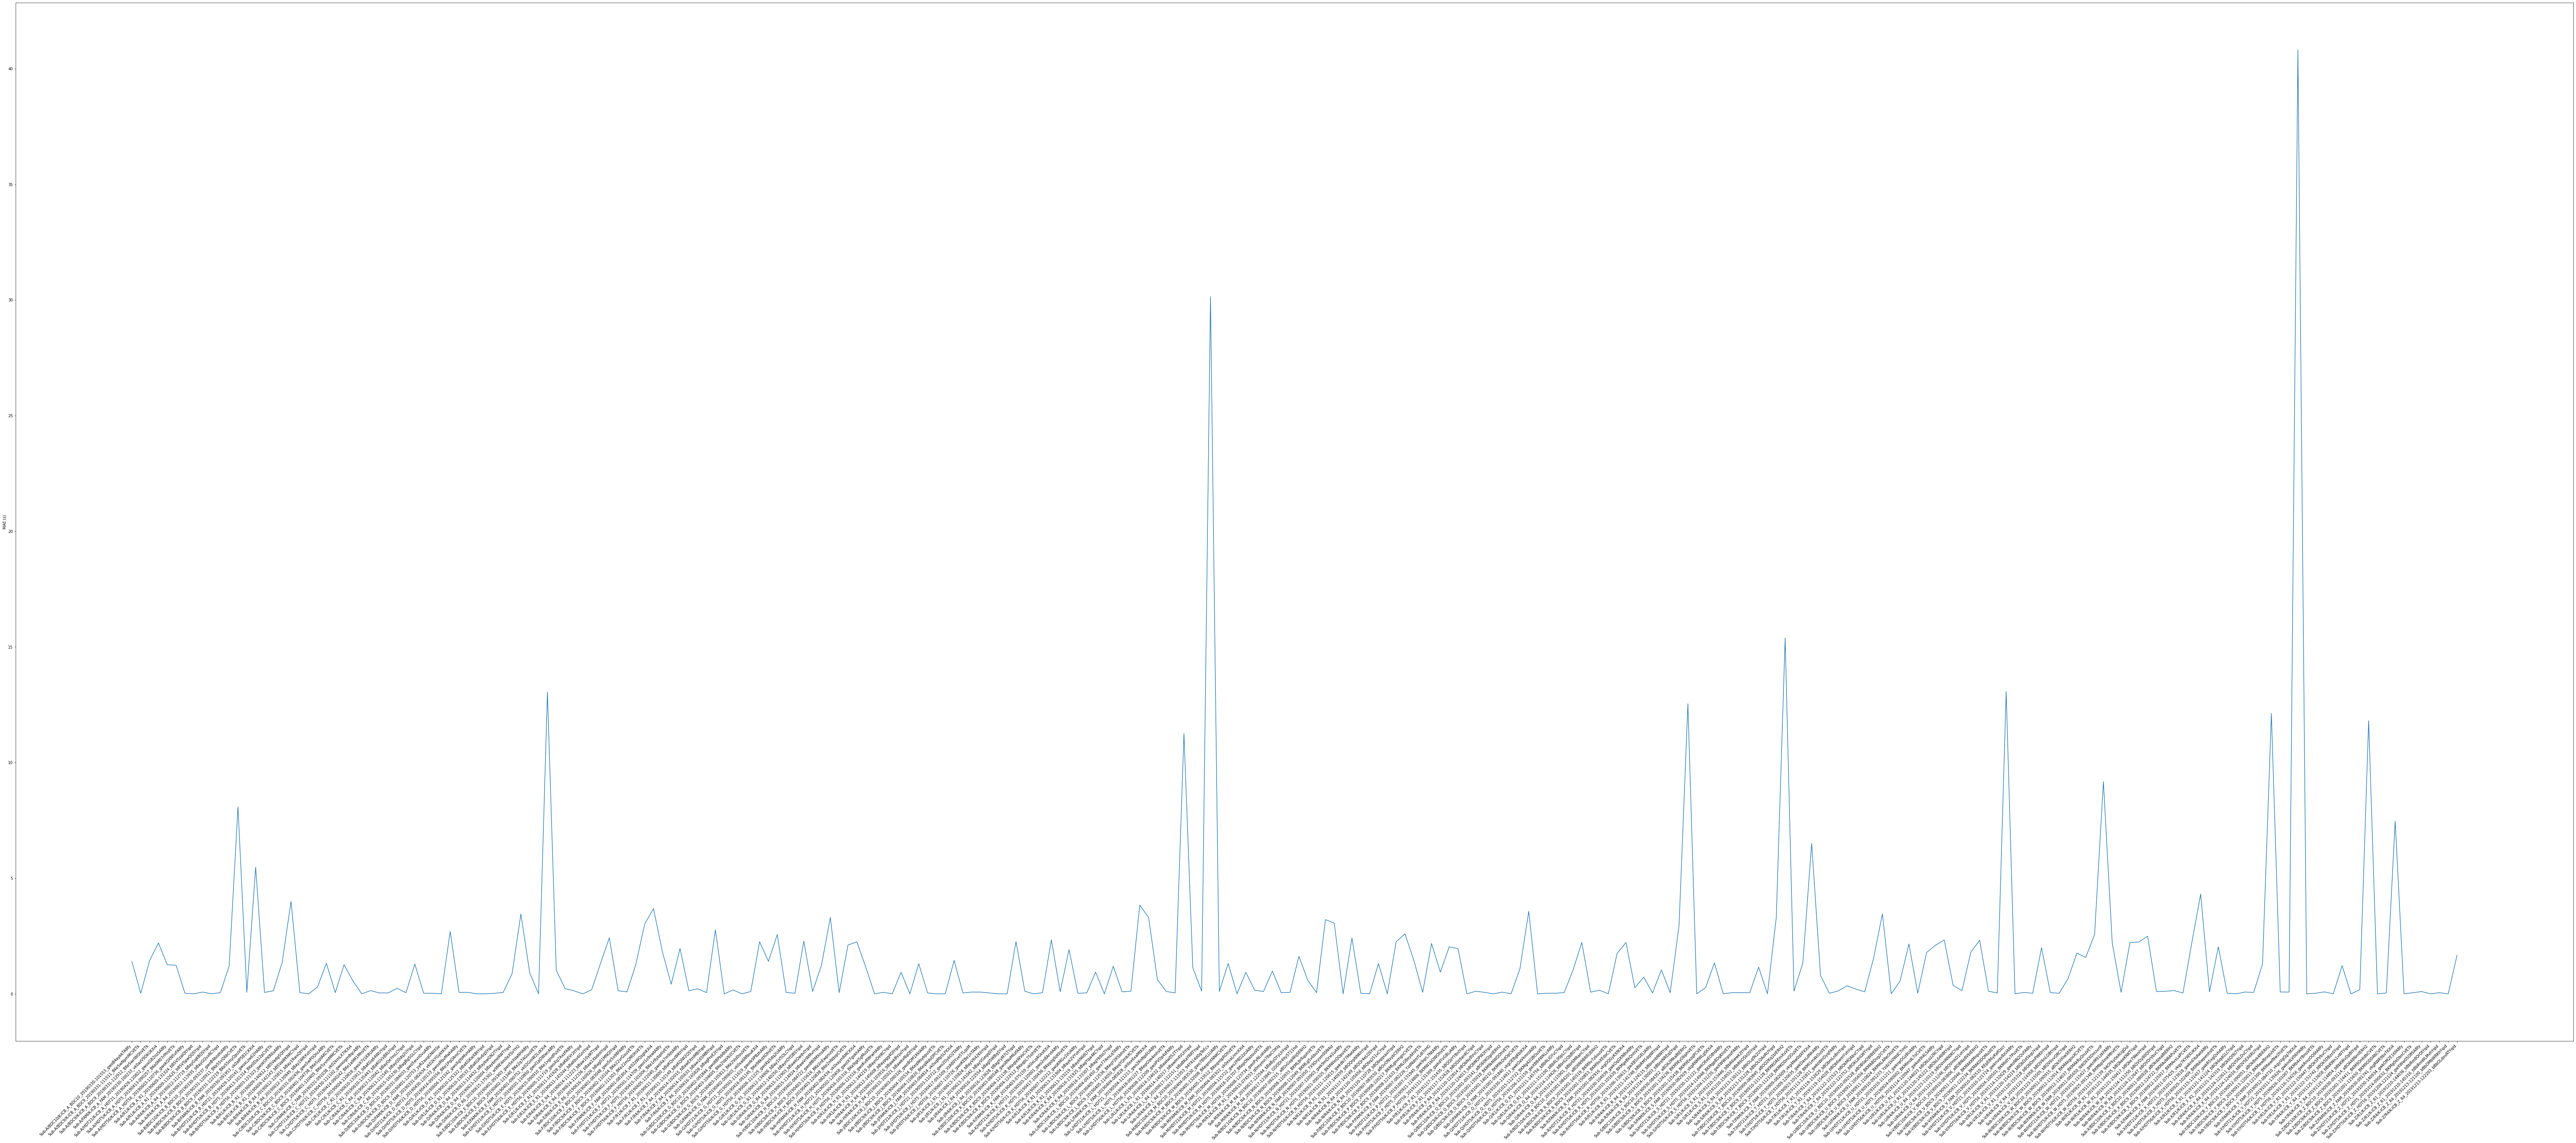

In [25]:
plt.figure(figsize=(120, 50))
x = np.array(range(len(sec_path_all)))
my_xticks = sec_path_all
plt.xticks(x, my_xticks, rotation=45, ha="right")
plt.plot(my_xticks, err_all)
plt.ylabel("MAE (s)")

In [26]:
import pickle

with open("/home/giuseppeditursi/Desktop/Respiration_from_SCG/2_Resp_Extraction/1_MA_median/MAmedian_err_all", "wb") as fp:   #Pickling
    pickle.dump(err_all, fp)